In [48]:
# Load required libraries and setup utilities for analysis.
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
from scipy import signal
from scipy import linalg

#data analysis utils
import seaborn as sns
import sys, sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP

#test:
print(sys.executable)
print(sklearn.__version__)

c:\Users\sindr\Documents\Code\acoustic blockage sensor\.venv\Scripts\python.exe
1.8.0


In [49]:
plt.rcParams.update({
    "figure.figsize": (14, 5),   # wider default
    "figure.dpi": 120,           # clearer on laptop displays
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
})

## Data loading and acceptable file structures

This notebook scans one root folder (`master_dir`) and builds two tables:
- `exp_df`: experiment recordings
- `baseline_df`: baseline recordings

How folder parsing works:
- Each immediate subfolder under `master_dir` must match `Ø{diameter}w{width}` or `Ø{diameter}_w{width}` (examples: `Ø20w40`, `Ø46w0`).
- These values become `diameter_mm` and `width_mm`.
- Only audio files directly inside each config folder are scanned (not nested subfolders).

How files are classified:
- If filename stem contains `baseline` (case-insensitive), the file is added to `baseline_df`.
- Otherwise, a position must be found from filename using patterns like `pos1`, `pos_2`, `p3`; those files go to `exp_df`.
- Non-baseline files without a detectable position are ignored.

Supported audio extensions:
- `.wav`, `.flac`, `.mp3`, `.ogg`, `.m4a`

Recommended structure:
```text
data/3m straight pipe/first_test/
  Ø46w0/
    baseline.WAV
    baseline1.WAV        # optional additional baseline
  Ø20w40/
    pos1.WAV
    pos2.WAV
  Ø20w120/
    pos1.WAV
    ...
```

Important behavior with multiple baselines:
- Loading will include all files containing `baseline` in their names.
- Later analysis currently uses `baseline_df.iloc[0]` as the reference baseline, so if multiple baseline files exist, only the first one is used unless the code is changed.

Practical naming tips:
- Keep experiment files as `pos{n}.WAV` (or `p{n}.WAV`) for reliable position parsing.
- Use `baseline` in baseline filenames (`baseline.WAV`, `baseline1.WAV`, etc.).
- Avoid putting non-measurement files in config folders.


> Note: This section explains data loading and the extracted metadata/features.


# Data loading & feature extraction:


## Feature explanation
- diameter_mm (int) — the insert diameter (Ø)
- width_mm (int) — the insert width (w)
- position (int or str) — the measurement position (1–5, or actual distance)
- fs (int) — sampling frequency
- y (object) — the signal array (mono, 1D numpy array)



In [50]:
# Initialize a container to collect engineered feature records.
feature_list = []

In [51]:
# Set the master dataset path and prepare core experiment dataframes.
master_dir = Path(r"data\3m straight pipe\first_test")

In [52]:
# Accept: Ø20w120  OR Ø20_w120  (case-insensitive w)
CONFIG_RE = re.compile(r"^\u00D8(?P<diameter>\d+)_?w(?P<width>\d+)$", re.IGNORECASE)

# Accept: pos1, Position_3, p5, etc. (first integer after 'pos' if present, else None)
POS_RE = re.compile(r"(?:pos|p)\s*[_-]?\s*(?P<pos>\d+)", re.IGNORECASE)

def parse_config(folder_name: str) -> tuple[int, int]:
    m = CONFIG_RE.match(folder_name)
    if not m:
        raise ValueError(f"Folder name '{folder_name}' does not match '\u00D8{{diameter}}w{{width}}' or '\u00D8{{diameter}}_w{{width}}'")
    return int(m.group("diameter")), int(m.group("width"))

def parse_position(file_path: Path) -> int | None:
    m = POS_RE.search(file_path.stem)
    if not m:
        return None
    return int(m.group("pos"))

In [53]:
# Scan dataset folders and build a metadata-only index dataframe.
# Cell 3: scan dataset and build a metadata-only DataFrame (no audio loaded yet)


def build_index_df(
    root: Path,
    exts=(".wav", ".flac", ".mp3", ".ogg", ".m4a"),
    baseline_names=("baseline",),
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Build experiment and baseline metadata tables by scanning the dataset tree."""

    exp_rows = []
    baseline_rows = []

    for cfg_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        diameter_mm, width_mm = parse_config(cfg_dir.name)

        # Only process files directly inside each config folder
        for f in sorted(cfg_dir.iterdir()):
            if not (f.is_file() and f.suffix.lower() in exts):
                continue

            stem_lower = f.stem.lower()
            is_baseline = any(tok in stem_lower for tok in baseline_names)

            if is_baseline:
                baseline_rows.append({
                    "diameter_mm": diameter_mm,
                    "width_mm": width_mm,
                    "file_path": str(f),
                })
            else:
                pos = parse_position(f)
                if pos is None:
                    continue  # ignore non-baseline files without position
                exp_rows.append({
                    "diameter_mm": diameter_mm,
                    "width_mm": width_mm,
                    "position": pos,
                    "file_path": str(f),
                })

    exp_df = (
        pd.DataFrame(exp_rows)
        .sort_values(["diameter_mm", "width_mm", "position"])
        .reset_index(drop=True)
    )

    baseline_df = (
        pd.DataFrame(baseline_rows)
        .sort_values(["diameter_mm", "width_mm"])
        .reset_index(drop=True)
    )

    return exp_df, baseline_df


exp_df, baseline_df = build_index_df(master_dir)

exp_df.head()
#baseline_df.head()


,diameter_mm,width_mm,position,file_path
0,20,40,1,data\3m straight pipe\first_test\Ø20w40\pos1.WAV
1,20,40,2,data\3m straight pipe\first_test\Ø20w40\pos2.WAV
2,20,40,3,data\3m straight pipe\first_test\Ø20w40\pos3.WAV
3,20,40,4,data\3m straight pipe\first_test\Ø20w40\pos4.WAV
4,20,40,5,data\3m straight pipe\first_test\Ø20w40\pos5.WAV


In [54]:
# Attach audio waveforms and sampling rates to the indexed metadata.
# Cell 4: load audio for a given df

def attach_audio(df: pd.DataFrame) -> pd.DataFrame:
    """Load audio files listed in df and append fs, waveform, length, and duration columns."""
    xs = []
    fss = []

    for fp in df["file_path"]:
        x, fs = librosa.load(fp, sr=None, mono=False)

        if x.ndim == 1:
            x_mono = x
        else:
            x_mono = x[0]  # keep channel 0

        xs.append(x_mono.astype(np.float32))
        fss.append(int(fs))

    df = df.copy()
    df["fs"] = fss
    df["y"] = xs
    df["n_samples"] = df["y"].map(len)
    df["duration_s"] = df["n_samples"] / df["fs"]
    return df


exp_df = attach_audio(exp_df)
baseline_df = attach_audio(baseline_df)

baseline_df.head()


,diameter_mm,width_mm,file_path,fs,y,n_samples,duration_s
0,46,0,data\3m straight pipe\first_test\Ø46w0\baselin...,48000,"[-9.655952e-06, -7.1525574e-07, 2.8729439e-05,...",1575936,32.832


In [55]:
# Inspect recording sample counts to verify loaded audio lengths.
exp_df['n_samples']

0     1480064
1     1568448
2     1567296
3     1522624
4     1527744
5     1522624
6     1584384
7     1526912
8     1533696
9     1530048
10    1529152
11    1574720
12    1529408
13    1560704
14    1561536
15    1503168
16    1494464
17    1520064
18    1515840
19    1499712
Name: n_samples, dtype: int64

> Note: This section introduces signal treatment and normalization steps.


# Data treatment

In [56]:
# Define preprocessing helpers to center and standardize signal lengths.
#make all audio signals the same length by centering on a set amount on observations

def compute_target_length(df: pd.DataFrame, seconds_each_side: float = 2.0) -> int:
    """Compute a common centered length after trimming both ends of each recording."""
    if df["fs"].nunique() != 1:
        raise ValueError("Sampling frequencies differ.")

    fs = df["fs"].iloc[0]
    min_len = df["y"].map(len).min()
    trim_each_side = int(seconds_each_side * fs)

    desired_n_obs = min_len - 2 * trim_each_side

    if desired_n_obs <= 0:
        raise ValueError("Signals too short for requested trimming.")

    return desired_n_obs

def center_all_to_length(df: pd.DataFrame, target_length: int) -> pd.DataFrame:
    """Center-crop all signals to the same target length and update metadata columns."""
    df = df.copy()

    def center_crop(y):
        """Return the centered slice of one 1D signal with the requested target length."""
        current_length = len(y)
        if current_length < target_length:
            raise ValueError("Signal shorter than target length.")

        start = (current_length - target_length) // 2
        end = start + target_length
        return y[start:end]

    df["y_centered"] = df["y"].apply(center_crop)
    df["n_samples"] = target_length
    df["duration_s"] = target_length / df["fs"]

    return df


In [57]:
# Apply length normalization and split data into baseline and experiment sets.
target_obs = compute_target_length(exp_df)
exp_df = center_all_to_length(exp_df, target_obs)
baseline_df = center_all_to_length(baseline_df, target_obs)

In [58]:
# Check that centered signals have consistent lengths across rows.
def check_signal_lengths(df: pd.DataFrame, signal_col: str = "y_centered") -> None:
    """Validate signal dimensionality and metadata consistency, then print a summary report."""
    if signal_col not in df.columns:
        raise ValueError(f"Column '{signal_col}' not found in dataframe.")

    lengths = []
    problems = []

    for idx, row in df.iterrows():
        y = row[signal_col]

        if not isinstance(y, np.ndarray):
            problems.append((idx, "Not numpy array"))
            continue

        if y.ndim != 1:
            problems.append((idx, "Signal not 1D"))

        lengths.append(len(y))

        if "n_samples" in df.columns:
            if len(y) != row["n_samples"]:
                problems.append((idx, "Mismatch with n_samples"))

        if "fs" in df.columns and "duration_s" in df.columns:
            expected_duration = len(y) / row["fs"]
            if not np.isclose(expected_duration, row["duration_s"]):
                problems.append((idx, "Mismatch with duration_s"))

    unique_lengths = set(lengths)

    print(f"Rows checked: {len(df)}")
    print(f"Unique signal lengths: {unique_lengths}")

    if problems:
        print("Problems found:")
        for p in problems:
            print(p)
    else:
        print("All signals consistent.")

check_signal_lengths(exp_df)
check_signal_lengths(baseline_df)


Rows checked: 20
Unique signal lengths: {1288064}
All signals consistent.
Rows checked: 1
Unique signal lengths: {1288064}
All signals consistent.


> Note: This section introduces handcrafted audio feature engineering.


# Feature engineering

## Standard sound driven features (play my pipes vol 1)

In [59]:
# Define standard acoustic feature functions (time and spectral domain).
#Playing the pipes vol 1 features

def zcr(x,fs):
    """Return mean zero-crossing rate for the input waveform."""
    return np.mean(librosa.zero_crossings(x))

def energy(x,fs):
    """Return signal energy proxy using the L2 norm of the waveform."""
    return scipy.linalg.norm(x)

def extract_mfcc(signal,fs):
    """Return mean MFCC vector across time frames."""
    # n_mfcc=50 #<- this may be changed
    mfcc=librosa.feature.mfcc(y=signal, sr=fs)
    mfccs = np.mean(mfcc.T,axis=0)
    return mfccs

def extract_spectral_centroid(signal,fs):
    """Return mean spectral centroid across frames."""
    return np.mean(librosa.feature.spectral_centroid(y=signal, sr=fs))

def spec_bw(signal,fs):
    """Return mean spectral bandwidth across frames."""
    return np.mean(librosa.feature.spectral_bandwidth(y=signal, sr=fs))

def extract_stft_mag(signal,fs):
    """Return mean log-magnitude STFT profile across time."""
    return np.mean(np.abs(librosa.amplitude_to_db(librosa.stft(signal,n_fft=2048,hop_length=512),ref=np.max)).T,axis=0)

def extract_stft_phase(signal,fs):
    """Return mean polynomial features computed from STFT phase-related representation."""
    return np.mean(librosa.feature.poly_features(S=np.angle(librosa.amplitude_to_db(librosa.stft(signal,n_fft=2048,hop_length=512),ref=np.max)),order=2).T,axis=0)

def chroma_stf(signal,fs):
    """Return mean chroma STFT value over all bins and frames."""
    return np.mean(librosa.feature.chroma_stft(y=signal, sr=fs))

def rmse(signal,fs):
    """Return mean RMS amplitude across frames."""
    return np.mean(librosa.feature.rms(y=signal))

def SpecRolloff(signal,fs):
    """Return mean spectral rolloff frequency across frames."""
    return np.mean(librosa.feature.spectral_rolloff(y=signal, sr=fs))


In [60]:
# Define a helper to apply selected feature functions across the dataframe.
def apply_vol1_features(df: pd.DataFrame, feature_dict: dict, signal_col="y") -> pd.DataFrame:
    """Apply each feature function to every row and append scalar or vector outputs as columns."""

    df = df.copy()

    for feature_name, func in feature_dict.items():
        feature_values = []

        for _, row in df.iterrows():
            y = row[signal_col]
            fs = row["fs"]
            value = func(y, fs)
            feature_values.append(value)

        # Handle scalar vs vector features
        if isinstance(feature_values[0], np.ndarray):
            arr = np.vstack(feature_values)
            for i in range(arr.shape[1]):
                df[f"{feature_name}_{i}"] = arr[:, i]
        else:
            df[feature_name] = feature_values

    return df


In [61]:
# Configure the feature dictionary and run the first feature extraction pass.
vol1_feature_dict = {
    "zcr": zcr,
    "energy": energy,
    "mfcc": extract_mfcc,
    "spectral_centroid": extract_spectral_centroid,
    "spectral_bw": spec_bw,
    "rmse": rmse,
    "rolloff": SpecRolloff
}

> Note: This section introduces transfer-function-based feature extraction.


## Transfer function based features

### Sweep segmentation:

In [62]:
# Generate the logarithmic sweep reference signal for transfer-function analysis.
def make_log_sweep(fs: int, duration_s: float, f_start: float, f_end: float) -> np.ndarray:
    """Create a float32 logarithmic chirp used as the sweep reference signal."""
    t = np.arange(int(round(duration_s * fs))) / fs
    x = signal.chirp(t, f0=f_start, f1=f_end, t1=duration_s, method="logarithmic")
    x = x.astype(np.float32)
    return x

# Parameters (yours)
fs = int(exp_df["fs"].iloc[0])  # assumes single fs in exp_df
sweep_duration_s = 0.5
f_start = 100.0
f_end = 10_000.0

x_sweep = make_log_sweep(fs, sweep_duration_s, f_start, f_end)

len(x_sweep), x_sweep[:10]


(24000,
 array([1.        , 0.9999143 , 0.9996572 , 0.9992286 , 0.9986285 ,
        0.99785686, 0.9969138 , 0.9957993 , 0.9945135 , 0.9930565 ],
       dtype=float32))

fs: 48000
sweep samples: 24000
sweep duration (s): 0.5


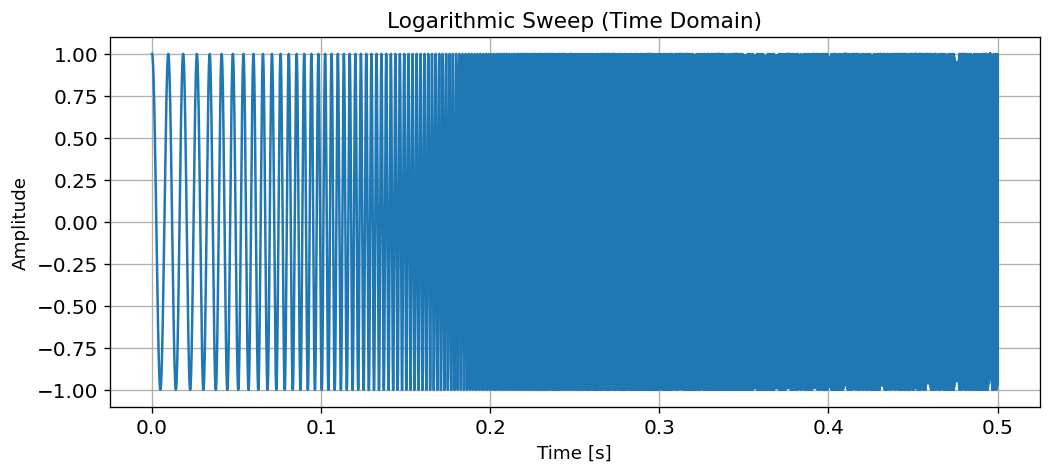

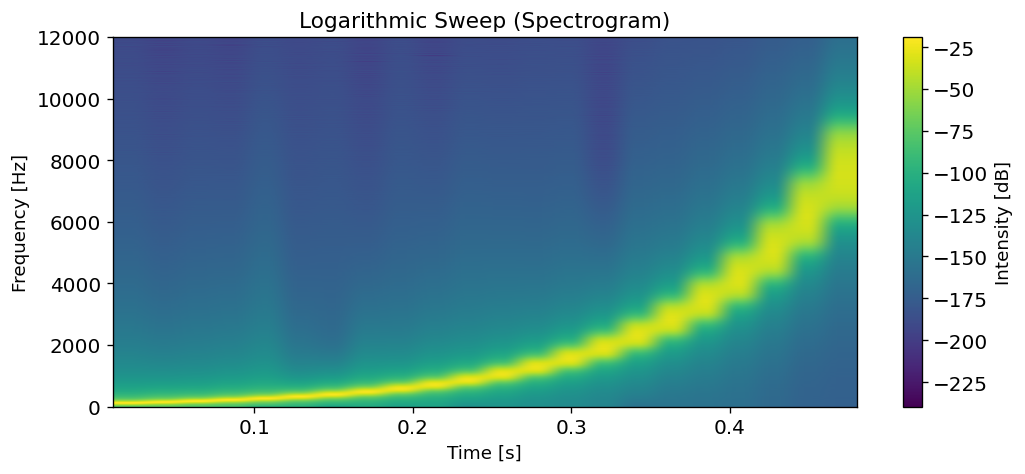

In [63]:
# Sanity-check sweep and sampling parameters before further processing.
print("fs:", fs)
print("sweep samples:", len(x_sweep))
print("sweep duration (s):", len(x_sweep)/fs)

t = np.arange(len(x_sweep)) / fs

plt.figure(figsize=(10, 4))
plt.plot(t, x_sweep)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Logarithmic Sweep (Time Domain)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.specgram(x_sweep, Fs=fs, NFFT=2048, noverlap=1024, cmap="viridis")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Logarithmic Sweep (Spectrogram)")
plt.ylim(0, 12000)
plt.colorbar(label="Intensity [dB]")
plt.show()

In [64]:
# Define sweep-start detection using correlation with the reference sweep.
def find_sweep_start(y: np.ndarray, x_sweep: np.ndarray) -> int:
    """Estimate the sample index where the reference sweep best aligns within y."""
    y = np.asarray(y).ravel()
    x = np.asarray(x_sweep).ravel()

    # Normalize to reduce sensitivity to gain differences
    y0 = y - np.mean(y)
    x0 = x - np.mean(x)

    # Matched filter: correlate y with x
    corr = signal.fftconvolve(y0, x0[::-1], mode="valid")
    start = int(np.argmax(corr))
    return start

def add_sweep_alignment_info(df: pd.DataFrame, x_sweep: np.ndarray, signal_col="y") -> pd.DataFrame:
    df = df.copy()
    sweep_len = len(x_sweep)

    starts = []
    ns = []

    for y in df[signal_col]:
        start = find_sweep_start(y, x_sweep)
        y2 = np.asarray(y).ravel()[start:]
        n = len(y2) // sweep_len
        starts.append(start)
        ns.append(n)

    df["sweep_start_idx"] = starts
    df["n_sweeps_available"] = ns
    return df

exp_df = add_sweep_alignment_info(exp_df, x_sweep)
baseline_df = add_sweep_alignment_info(baseline_df, x_sweep)



#OLD stuff below =======================================================


# def segment_into_sweeps(y: np.ndarray, start: int, sweep_len: int):
#     """Slice a signal into consecutive full-length sweep segments starting at start."""
#     y2 = np.asarray(y).ravel()[start:]
#     n = len(y2) // sweep_len
#     y2 = y2[:n * sweep_len]
#     return y2.reshape(n, sweep_len), n


In [65]:
#Getting sweep alignment info for all rows in the dataframes and adding new columns for sweep start index and number of full sweeps available.

exp_df = add_sweep_alignment_info(exp_df, x_sweep)
baseline_df = add_sweep_alignment_info(baseline_df, x_sweep)

In [66]:
#debug

exp_df[["diameter_mm","width_mm","position","sweep_start_idx","n_sweeps_available"]].head()

,diameter_mm,width_mm,position,sweep_start_idx,n_sweeps_available
0,20,40,1,221982,52
1,20,40,2,389950,49
2,20,40,3,316042,52
3,20,40,4,186966,55
4,20,40,5,612975,38


### Sweep visualization (debugging)

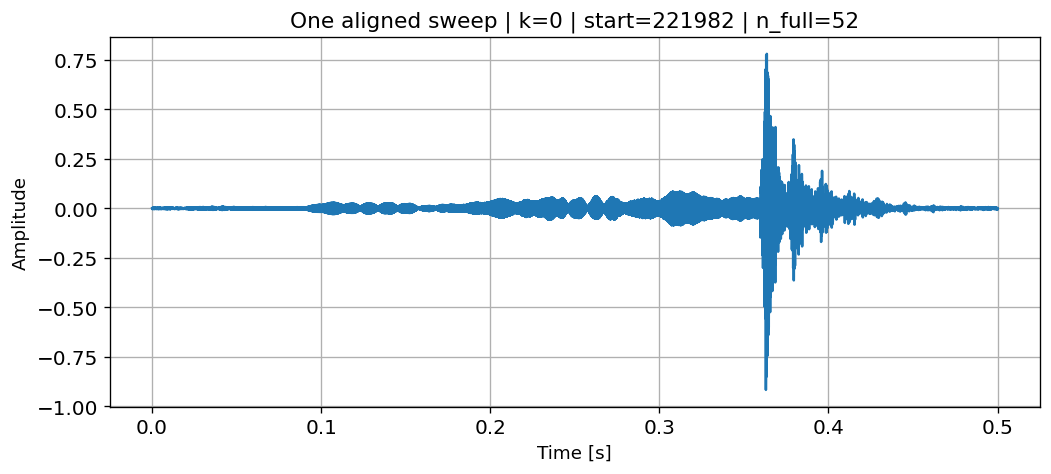

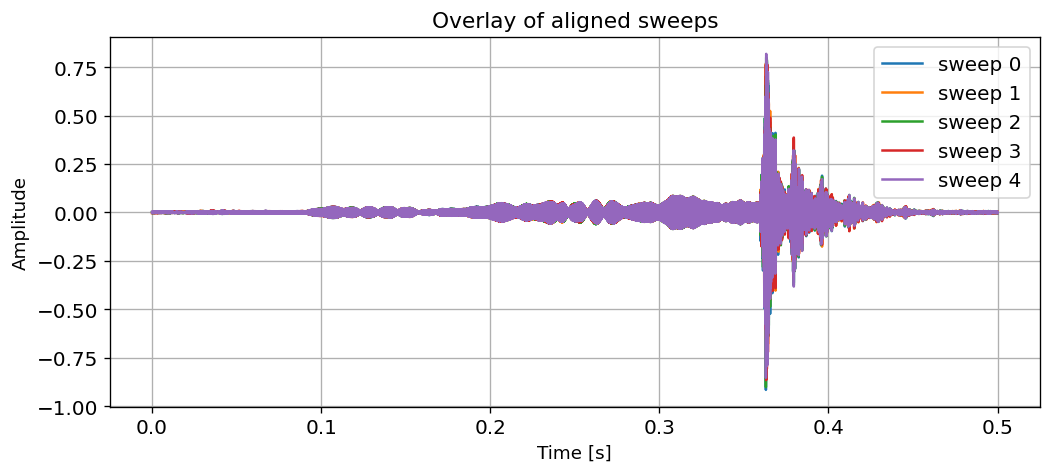

In [67]:
def plot_aligned_sweeps_from_row_no_segment(
    row,
    x_sweep: np.ndarray,
    n_show: int = 3,
    start_sweep: int = 0,
    signal_col: str = "y",
    fs_col: str = "fs",
    start_col: str = "sweep_start_idx",
):
    y = np.asarray(row[signal_col]).ravel()
    fs = int(row[fs_col])
    sweep_len = len(x_sweep)

    if start_col in row and pd.notna(row[start_col]):
        start = int(row[start_col])
    else:
        start = find_sweep_start(y, x_sweep)

    n_full = (len(y) - start) // sweep_len
    if n_full <= 0:
        raise ValueError("No full sweeps available after alignment.")

    end_sweep = min(start_sweep + n_show, n_full)
    if start_sweep >= end_sweep:
        raise ValueError(f"Requested start_sweep={start_sweep}, but only n_full={n_full} sweeps available.")

    t = np.arange(sweep_len) / fs

    # Plot first selected sweep
    k = start_sweep
    i0 = start + k * sweep_len
    i1 = i0 + sweep_len
    sweep0 = y[i0:i1]

    plt.figure(figsize=(10, 4))
    plt.plot(t, sweep0)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(f"One aligned sweep | k={k} | start={start} | n_full={n_full}")
    plt.grid(True)
    plt.show()

    # Overlay several sweeps
    plt.figure(figsize=(10, 4))
    for k in range(start_sweep, end_sweep):
        i0 = start + k * sweep_len
        i1 = i0 + sweep_len
        plt.plot(t, y[i0:i1], label=f"sweep {k}")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title("Overlay of aligned sweeps")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
plot_aligned_sweeps_from_row_no_segment(exp_df.iloc[0], x_sweep, n_show=5, start_sweep=0)

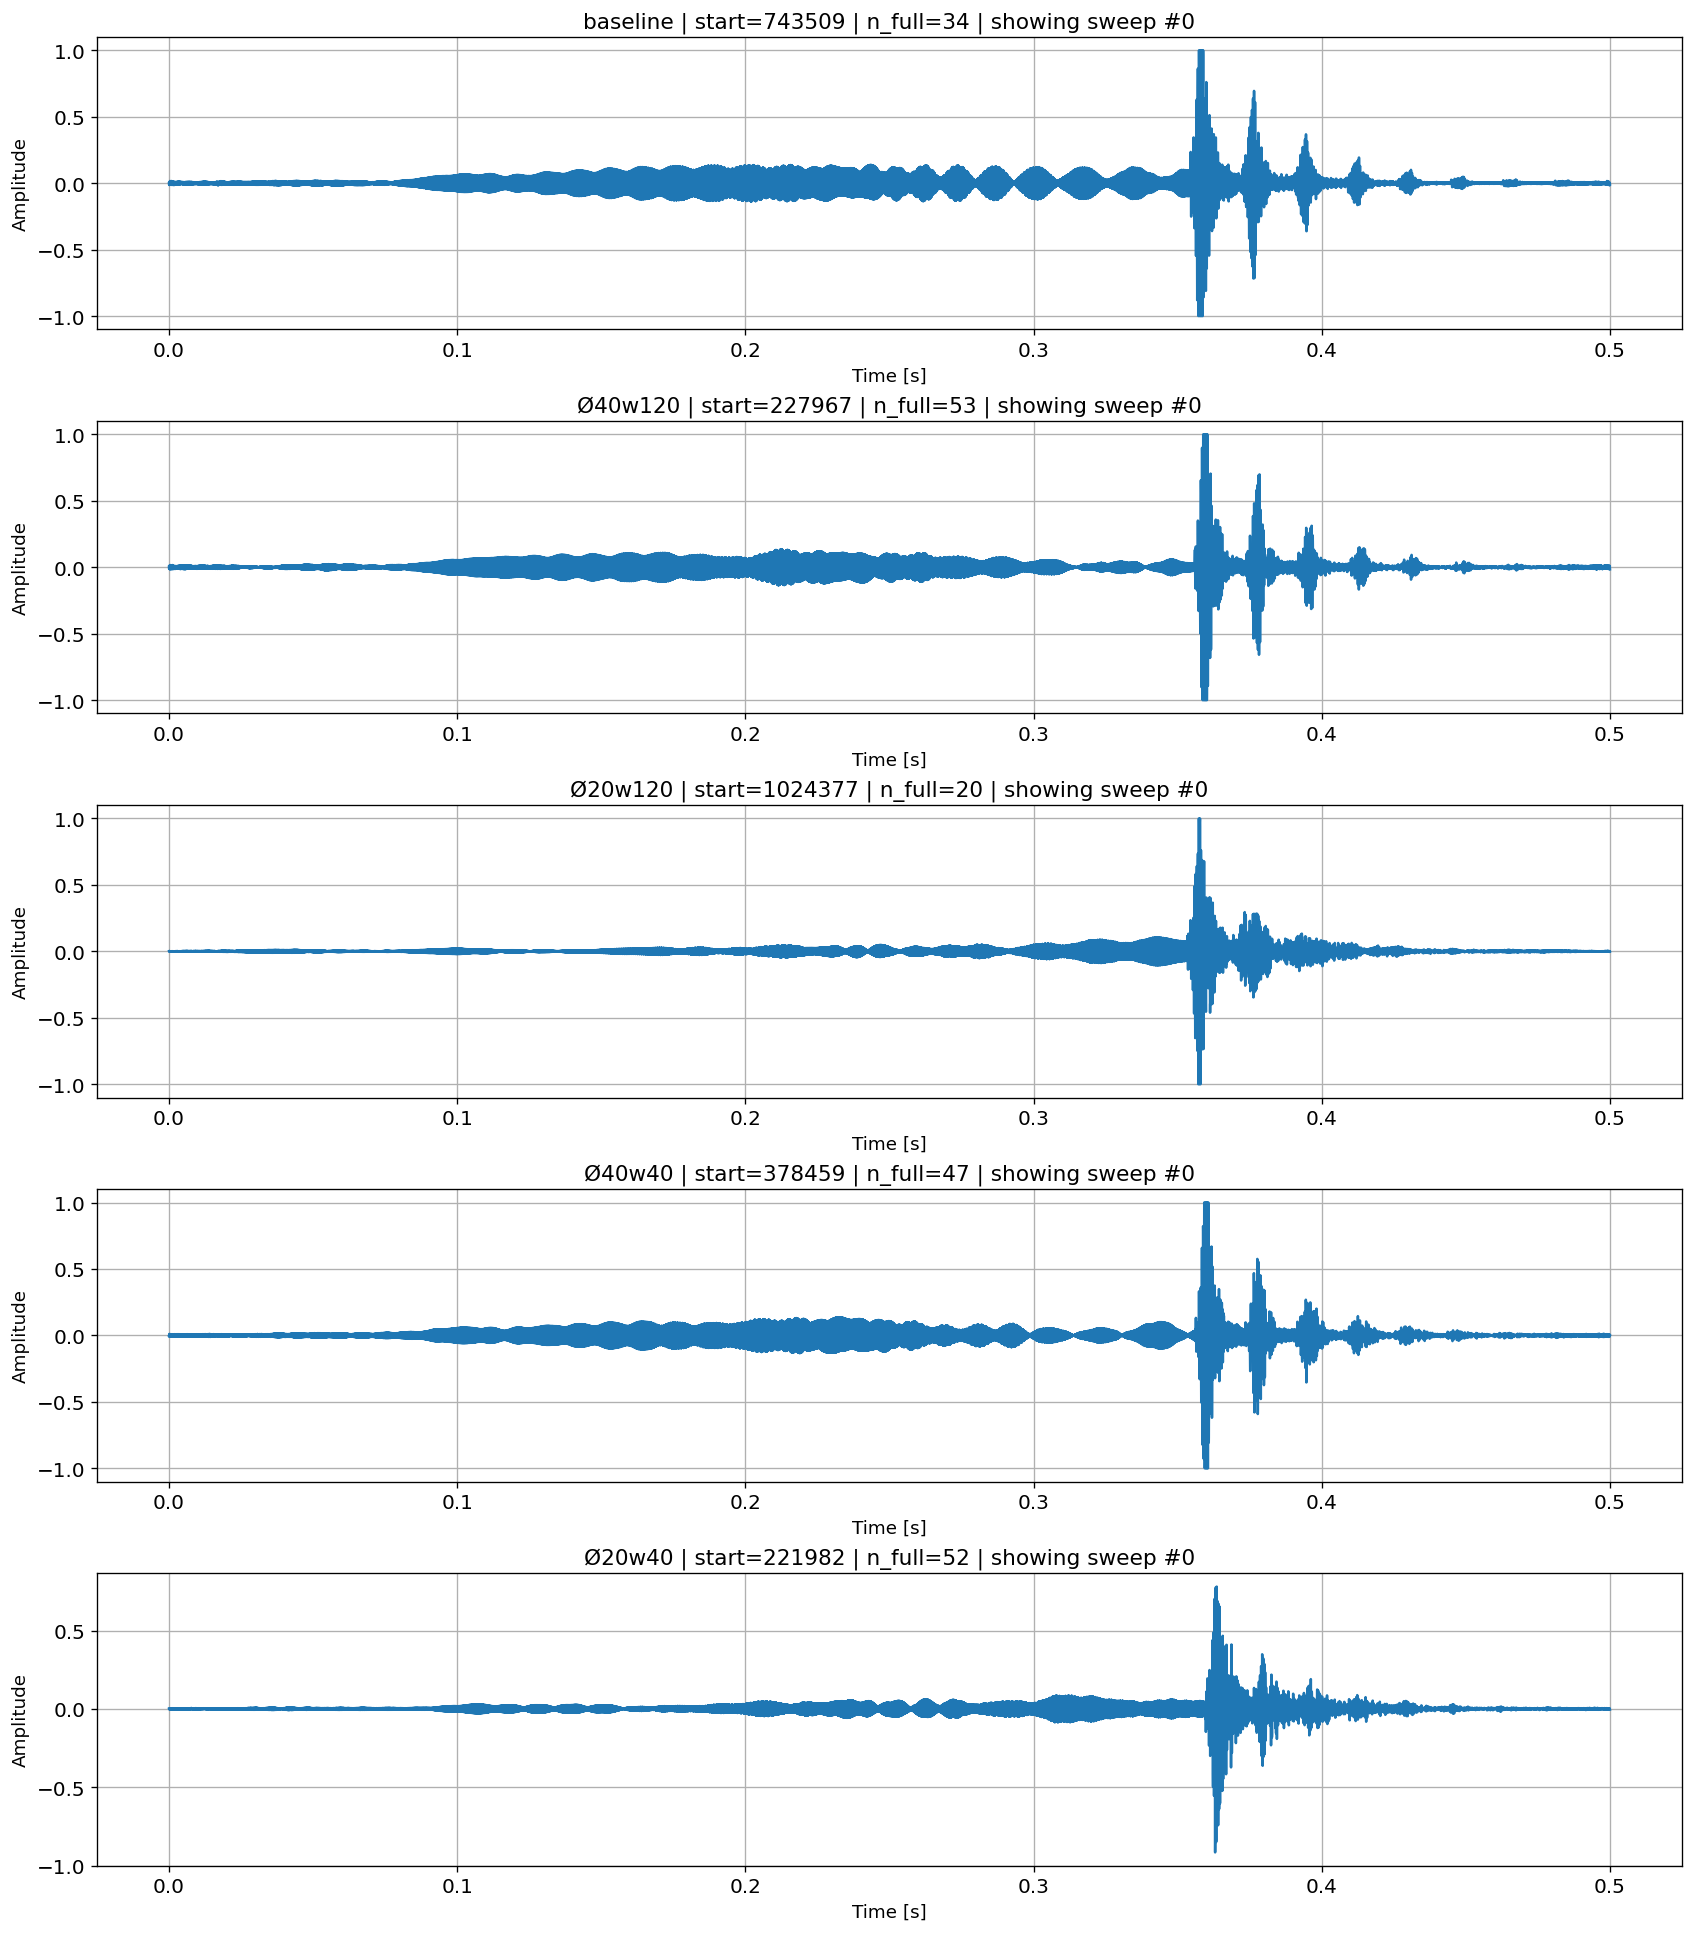

In [68]:
def plot_one_aligned_sweep_per_insert_no_segment(
    exp_df: pd.DataFrame,
    baseline_df: pd.DataFrame,
    x_sweep: np.ndarray,
    inserts=None,
    sweep_index: int = 0,
    signal_col: str = "y",
    fs_col: str = "fs",
    start_col: str = "sweep_start_idx",
):
    if inserts is None:
        inserts = [(40, 120), (20, 120), (40, 40), (20, 40)]

    rows = [("baseline", baseline_df.iloc[0])]

    for (d, w) in inserts:
        sub = exp_df[(exp_df["diameter_mm"] == d) & (exp_df["width_mm"] == w)]
        if sub.empty:
            raise ValueError(f"No rows found for Ø{d}w{w}")
        rows.append((f"Ø{d}w{w}", sub.iloc[0]))

    fs0 = int(rows[0][1][fs_col])
    for label, r in rows:
        if int(r[fs_col]) != fs0:
            raise ValueError("Different fs detected; regenerate x_sweep per fs or resample first.")

    sweep_len = len(x_sweep)
    fig, axes = plt.subplots(len(rows), 1, figsize=(14, 3.2 * len(rows)), sharex=False, constrained_layout=True)
    if len(rows) == 1:
        axes = [axes]

    for ax, (label, r) in zip(axes, rows):
        y = np.asarray(r[signal_col]).ravel()
        fs = int(r[fs_col])

        start = int(r[start_col]) if start_col in r and pd.notna(r[start_col]) else find_sweep_start(y, x_sweep)
        n_full = (len(y) - start) // sweep_len

        if n_full <= 0:
            raise ValueError(f"{label}: no full sweeps available after alignment.")
        if sweep_index >= n_full:
            raise ValueError(f"{label}: sweep_index={sweep_index}, but only n_full={n_full} available.")

        i0 = start + sweep_index * sweep_len
        i1 = i0 + sweep_len
        s = y[i0:i1]

        t = np.arange(sweep_len) / fs
        ax.plot(t, s)
        ax.set_title(f"{label} | start={start} | n_full={n_full} | showing sweep #{sweep_index}")
        ax.set_xlabel("Time [s]")
        ax.set_ylabel("Amplitude")
        ax.grid(True)

    plt.show()

plot_one_aligned_sweep_per_insert_no_segment(exp_df, baseline_df, x_sweep, sweep_index=0)

### Creating relative transfer function & feature extraction

In [69]:
# -------- Compute averaged |Y(f)| from aligned sweeps (no sweep-matrix stored) --------

def avg_mag_spectrum_from_aligned(
    y: np.ndarray,
    fs: int,
    start_idx: int,
    sweep_len: int,
    nfft: int | None = None,
    min_sweeps: int = 5,
    max_sweeps: int | None = None,
    window: str = "hann",
):
    """
    Uses start_idx to take full sweeps of length sweep_len from y, windows each sweep,
    FFTs each sweep, and averages magnitude spectra across sweeps.

    Returns: f, mag_mean, n_used
    """
    y = np.asarray(y).ravel()
    start_idx = int(start_idx)

    if start_idx < 0 or start_idx >= len(y):
        raise ValueError("start_idx out of bounds.")

    n_full = (len(y) - start_idx) // sweep_len
    if n_full < min_sweeps:
        raise ValueError(f"Only {n_full} full sweeps available; need at least {min_sweeps}.")

    n_used = n_full if max_sweeps is None else min(n_full, max_sweeps)

    if nfft is None:
        nfft = int(2 ** np.ceil(np.log2(sweep_len)))  # next pow2 >= sweep_len

    if window.lower() in ("hann", "hanning"):
        win = np.hanning(sweep_len).astype(np.float32)
    elif window.lower() in ("rect", "rectangular", "boxcar", "none"):
        win = np.ones(sweep_len, dtype=np.float32)
    else:
        raise ValueError(f"Unknown window: {window}")

    mag_acc = None

    for k in range(n_used):
        i0 = start_idx + k * sweep_len
        i1 = i0 + sweep_len
        seg = y[i0:i1] * win

        Y = np.fft.rfft(seg, n=nfft)
        mag = np.abs(Y)

        if mag_acc is None:
            mag_acc = mag.astype(np.float64)
        else:
            mag_acc += mag

    mag_mean = (mag_acc / n_used).astype(np.float64)
    f = np.fft.rfftfreq(nfft, d=1 / fs)

    return f, mag_mean, n_used

In [70]:
# -------- Baseline once, then relative curves for all exp rows --------

def compute_relative_transfer_curves(
    exp_df: pd.DataFrame,
    baseline_df: pd.DataFrame,
    x_sweep: np.ndarray,
    signal_col: str = "y",
    fs_col: str = "fs",
    start_col: str = "sweep_start_idx",
    min_sweeps: int = 5,
    max_sweeps: int | None = None,
    nfft: int | None = None,
    window: str = "hann",
    eps: float = 1e-12,
) -> tuple[pd.DataFrame, dict]:
    """
    Stage B:
      1) compute baseline averaged spectrum once
      2) compute exp averaged spectrum per row
      3) compute M_rel_db = 20*log10(|Yexp|/|Ybase|)
      4) store per-row f, M_rel_db, n_sweeps_used
    Returns:
      - updated exp_df
      - diagnostics dict (baseline f, baseline mag, baseline sweep count)
    """
    exp_df = exp_df.copy()

    # basic checks
    if exp_df[fs_col].nunique() != 1 or baseline_df[fs_col].nunique() != 1:
        raise ValueError("Different fs detected; handle per-row fs or resample.")
    fs_exp = int(exp_df[fs_col].iloc[0])
    fs_base = int(baseline_df[fs_col].iloc[0])
    if fs_exp != fs_base:
        raise ValueError("Baseline fs differs from experiment fs.")

    sweep_len = len(x_sweep)

    # baseline spectrum once (use first baseline row)
    b = baseline_df.iloc[0]
    f_base, mag_base, n_base = avg_mag_spectrum_from_aligned(
        y=b[signal_col],
        fs=fs_exp,
        start_idx=b[start_col],
        sweep_len=sweep_len,
        nfft=nfft,
        min_sweeps=min_sweeps,
        max_sweeps=max_sweeps,
        window=window,
    )

    # experiment spectra and relative curves
    f_list = []
    Mrel_list = []
    n_used_list = []

    for row in exp_df.itertuples(index=False):
        y = getattr(row, signal_col)
        start_idx = getattr(row, start_col)

        f, mag_exp, n_used = avg_mag_spectrum_from_aligned(
            y=y,
            fs=fs_exp,
            start_idx=start_idx,
            sweep_len=sweep_len,
            nfft=nfft if nfft is not None else (len(f_base) - 1) * 2,  # match baseline grid
            min_sweeps=min_sweeps,
            max_sweeps=max_sweeps,
            window=window,
        )

        if len(f) != len(f_base) or not np.allclose(f, f_base):
            raise ValueError("Frequency grids differ. Fix by passing a fixed nfft to all calls.")

        M_rel_db = 20.0 * np.log10((mag_exp + eps) / (mag_base + eps))

        f_list.append(f)
        Mrel_list.append(M_rel_db)
        n_used_list.append(n_used)

    exp_df["f"] = f_list
    exp_df["M_rel_db"] = Mrel_list
    exp_df["n_sweeps_used"] = n_used_list
    exp_df["n_sweeps_used_baseline"] = n_base

    diag = {"f_base": f_base, "mag_base": mag_base, "n_base": n_base, "fs": fs_exp, "sweep_len": sweep_len}
    return exp_df, diag

In [71]:
# -------- Features: band means, slopes, roll-off, simple peak + ripple metric --------

def _band_mean(f, M, lo, hi):
    m = (f >= lo) & (f < hi)
    return float(np.mean(M[m])) if np.any(m) else np.nan

def add_transfer_features(
    df: pd.DataFrame,
    f_col: str = "f",
    M_col: str = "M_rel_db",
    fmin: float = 100.0,
    fmax: float = 10_000.0,
    n_bands: int = 40,
    roll_ref_band=(200.0, 400.0),
    roll_drop_db: float = 6.0,
    slope_split_hz: float = 1000.0,
) -> pd.DataFrame:
    """
    Adds common features from M_rel_db(f):
      - 40 band averages over [fmin,fmax] (log10 spacing)
      - two slopes on log10(f): below and above slope_split_hz
      - roll-off frequency where M drops below ref_mean - roll_drop_db
      - peak frequency and peak height (max)
      - ripple metric: std of detrended M over band
    """
    df = df.copy()
    edges = np.logspace(np.log10(fmin), np.log10(fmax), n_bands + 1)

    band_cols = [f"band_{i:02d}_mean_db" for i in range(n_bands)]
    slope_lo_col = "slope_lo_db_per_dec"
    slope_hi_col = "slope_hi_db_per_dec"
    roll_col = f"rolloff_{int(roll_drop_db)}db_hz"
    peak_f_col = "peak_f_hz"
    peak_m_col = "peak_m_db"
    ripple_col = "ripple_std_db"

    out_rows = []

    for f, M in zip(df[f_col], df[M_col]):
        f = np.asarray(f)
        M = np.asarray(M)

        # limit to band of interest
        m = (f >= fmin) & (f <= fmax)
        f2 = f[m]
        M2 = M[m]

        feats = {}

        # band means
        for i in range(n_bands):
            feats[band_cols[i]] = _band_mean(f2, M2, edges[i], edges[i+1])

        # slopes vs log10(f)
        x = np.log10(f2)
        lo = f2 <= slope_split_hz
        hi = f2 >= slope_split_hz

        def fit_slope(mask):
            if np.sum(mask) < 5:
                return np.nan
            p = np.polyfit(x[mask], M2[mask], 1)  # M ≈ p0*log10(f)+p1
            return float(p[0])

        feats[slope_lo_col] = fit_slope(lo)
        feats[slope_hi_col] = fit_slope(hi)

        # roll-off frequency: first f where M <= ref_mean - roll_drop_db
        ref_m = (f2 >= roll_ref_band[0]) & (f2 <= roll_ref_band[1])
        ref_mean = float(np.mean(M2[ref_m])) if np.any(ref_m) else float(np.mean(M2))
        thresh = ref_mean - roll_drop_db
        below = np.where(M2 <= thresh)[0]
        feats[roll_col] = float(f2[below[0]]) if below.size else np.nan

        # peak
        i_peak = int(np.argmax(M2))
        feats[peak_f_col] = float(f2[i_peak])
        feats[peak_m_col] = float(M2[i_peak])

        # ripple metric: detrend linear in log-frequency then std
        if len(f2) >= 10:
            p = np.polyfit(x, M2, 1)
            M_detr = M2 - (p[0] * x + p[1])
            feats[ripple_col] = float(np.std(M_detr))
        else:
            feats[ripple_col] = np.nan

        out_rows.append(feats)

    feat_df = pd.DataFrame(out_rows)
    df = pd.concat([df.reset_index(drop=True), feat_df.reset_index(drop=True)], axis=1)
    return df

In [72]:
# compute per-row relative curves
exp_df, diag = compute_relative_transfer_curves(
    exp_df, baseline_df, x_sweep,
    min_sweeps=5,
    max_sweeps=None,
    nfft=None,          # or set fixed nfft for full reproducibility
    window="hann",
)

# Feature layer from M_rel_db
exp_df = add_transfer_features(exp_df)

#### Debugging/verification

In [73]:
#Debug / testing cell: check the new feature columns and their values

# Check columns exist
for col in ["f", "M_rel_db", "n_sweeps_used"]:
    print(col, "in exp_df:", col in exp_df.columns)

# Check shapes + finiteness for a few rows
for i in [0, len(exp_df)//2, len(exp_df)-1]:
    f = np.asarray(exp_df.iloc[i]["f"])
    M = np.asarray(exp_df.iloc[i]["M_rel_db"])
    print(f"Row {i}: len(f)={len(f)}, len(M)={len(M)}, finite(M)={np.isfinite(M).mean():.3f}")

# Check f grid identical across all rows
f0 = np.asarray(exp_df.iloc[0]["f"])
same_grid = all(np.allclose(np.asarray(rf), f0) for rf in exp_df["f"])
print("All rows share identical f grid:", same_grid)

f in exp_df: True
M_rel_db in exp_df: True
n_sweeps_used in exp_df: True
Row 0: len(f)=16385, len(M)=16385, finite(M)=1.000
Row 10: len(f)=16385, len(M)=16385, finite(M)=1.000
Row 19: len(f)=16385, len(M)=16385, finite(M)=1.000
All rows share identical f grid: True


In [74]:
# Identify band feature columns
band_cols = [c for c in exp_df.columns if c.startswith("band_") and c.endswith("_mean_db")]
other_cols = ["slope_lo_db_per_dec", "slope_hi_db_per_dec", "peak_f_hz", "peak_m_db", "ripple_std_db"]
roll_cols = [c for c in exp_df.columns if c.startswith("rolloff_") and c.endswith("_hz")]

print("Band cols:", len(band_cols))
print("Roll cols:", roll_cols)
print("Other cols present:", {c: (c in exp_df.columns) for c in other_cols})

# NaN rates
feat_cols = band_cols + other_cols + roll_cols
nan_rate = exp_df[feat_cols].isna().mean().sort_values(ascending=False)
print("Top NaN rates:")
print(nan_rate.head(10))

Band cols: 40
Roll cols: ['rolloff_6db_hz']
Other cols present: {'slope_lo_db_per_dec': True, 'slope_hi_db_per_dec': True, 'peak_f_hz': True, 'peak_m_db': True, 'ripple_std_db': True}
Top NaN rates:
band_00_mean_db    0.0
band_01_mean_db    0.0
band_02_mean_db    0.0
band_03_mean_db    0.0
band_04_mean_db    0.0
band_05_mean_db    0.0
band_06_mean_db    0.0
band_07_mean_db    0.0
band_08_mean_db    0.0
band_09_mean_db    0.0
dtype: float64


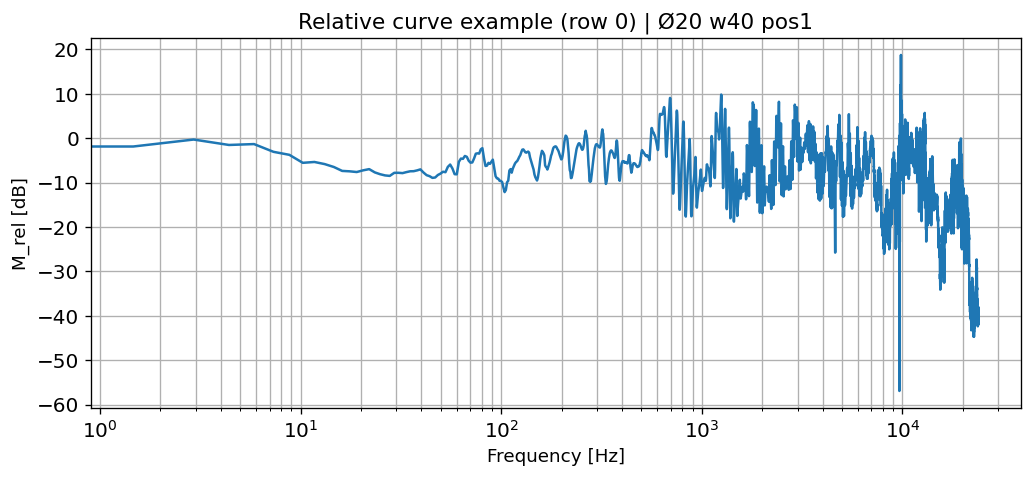

In [75]:
i = 0  # pick any row
f = np.asarray(exp_df.iloc[i]["f"])
M = np.asarray(exp_df.iloc[i]["M_rel_db"])

plt.figure(figsize=(10,4))
plt.plot(f, M)
plt.xscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel("M_rel [dB]")
plt.title(f"Relative curve example (row {i}) | Ø{exp_df.iloc[i]['diameter_mm']} w{exp_df.iloc[i]['width_mm']} pos{exp_df.iloc[i]['position']}")
plt.grid(True, which="both")
plt.show()


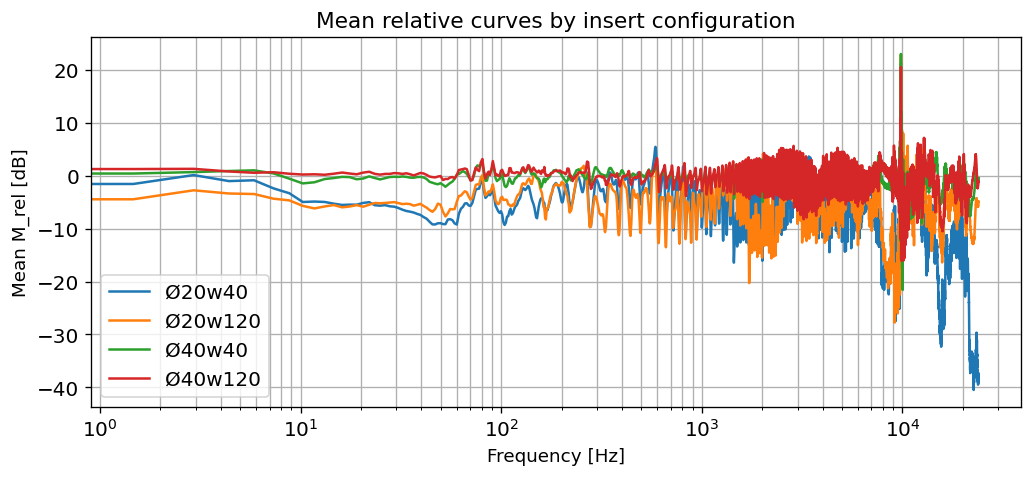

In [76]:
def mean_curve(group):
    Mstack = np.vstack(group["M_rel_db"].to_numpy())
    return Mstack.mean(axis=0)

means = exp_df.groupby(["diameter_mm","width_mm"]).apply(mean_curve)
f = np.asarray(exp_df.iloc[0]["f"])

plt.figure(figsize=(10,4))
for (d,w), Mmean in means.items():
    plt.plot(f, Mmean, label=f"Ø{d}w{w}")
plt.xscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Mean M_rel [dB]")
plt.title("Mean relative curves by insert configuration")
plt.grid(True, which="both")
plt.legend()
plt.show()

# Data Analysis

In [77]:
exp_df.columns

Index(['diameter_mm', 'width_mm', 'position', 'file_path', 'fs', 'y',
       'n_samples', 'duration_s', 'y_centered', 'sweep_start_idx',
       'n_sweeps_available', 'f', 'M_rel_db', 'n_sweeps_used',
       'n_sweeps_used_baseline', 'band_00_mean_db', 'band_01_mean_db',
       'band_02_mean_db', 'band_03_mean_db', 'band_04_mean_db',
       'band_05_mean_db', 'band_06_mean_db', 'band_07_mean_db',
       'band_08_mean_db', 'band_09_mean_db', 'band_10_mean_db',
       'band_11_mean_db', 'band_12_mean_db', 'band_13_mean_db',
       'band_14_mean_db', 'band_15_mean_db', 'band_16_mean_db',
       'band_17_mean_db', 'band_18_mean_db', 'band_19_mean_db',
       'band_20_mean_db', 'band_21_mean_db', 'band_22_mean_db',
       'band_23_mean_db', 'band_24_mean_db', 'band_25_mean_db',
       'band_26_mean_db', 'band_27_mean_db', 'band_28_mean_db',
       'band_29_mean_db', 'band_30_mean_db', 'band_31_mean_db',
       'band_32_mean_db', 'band_33_mean_db', 'band_34_mean_db',
       'band_35_mean_db',

In [78]:
#Separate out the relevant features as the X dataset for future ML modeling.

feature_cols = (
    [c for c in exp_df.columns if c.startswith("band_")] +
    ["slope_lo_db_per_dec",
     "slope_hi_db_per_dec",
     "rolloff_6db_hz",
     "peak_f_hz",
     "peak_m_db",
     "ripple_std_db"]
)

X = exp_df[feature_cols].copy()
meta = exp_df[["diameter_mm", "width_mm", "position"]].copy()

In [79]:
#check for missing values
print(X.isna().mean().sort_values(ascending=False).head())

band_00_mean_db    0.0
band_01_mean_db    0.0
band_02_mean_db    0.0
band_03_mean_db    0.0
band_04_mean_db    0.0
dtype: float64


In [80]:
#X.describe().T[["mean", "std", "min", "max"]]


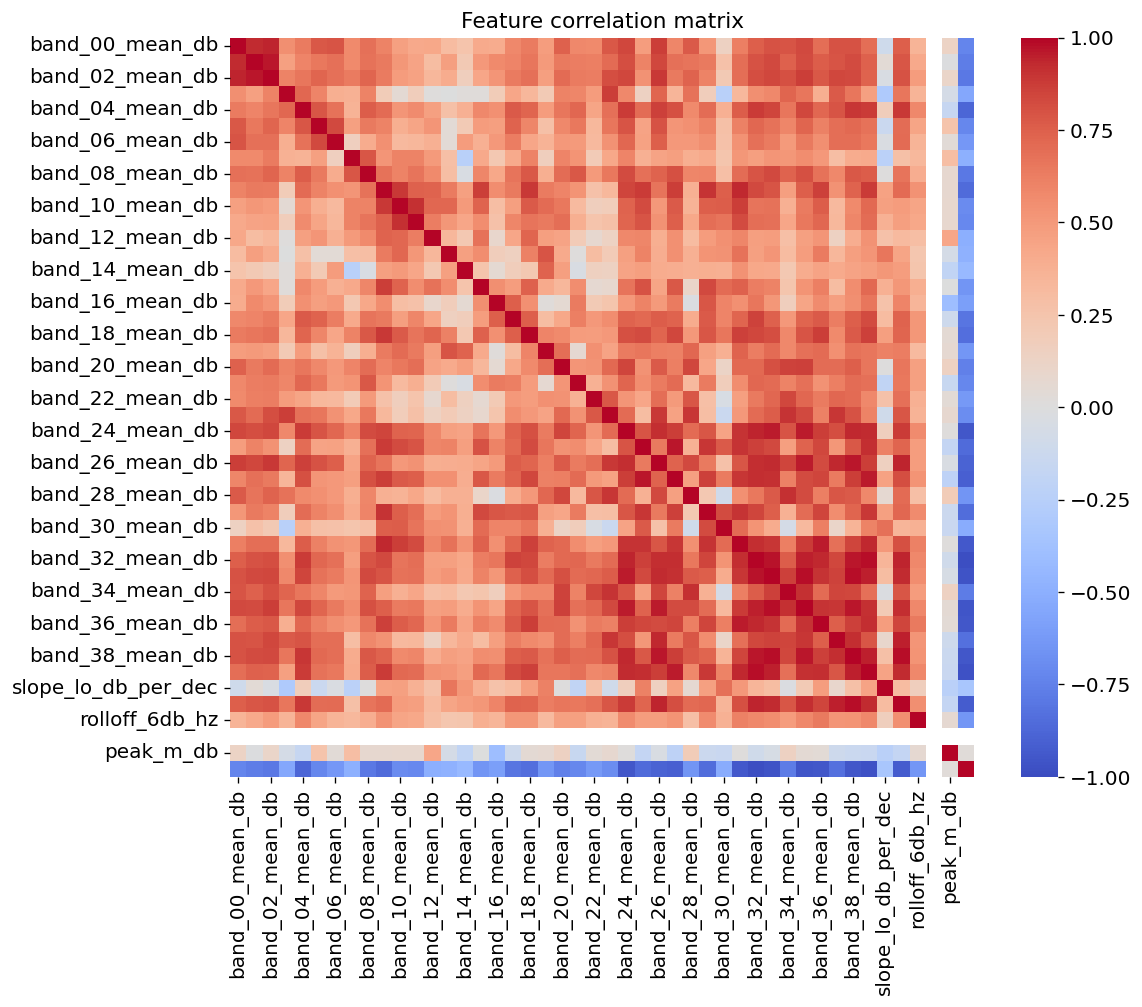

In [81]:
corr = X.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, vmax=1, vmin=-1)
plt.title("Feature correlation matrix")
plt.show()

## PCA

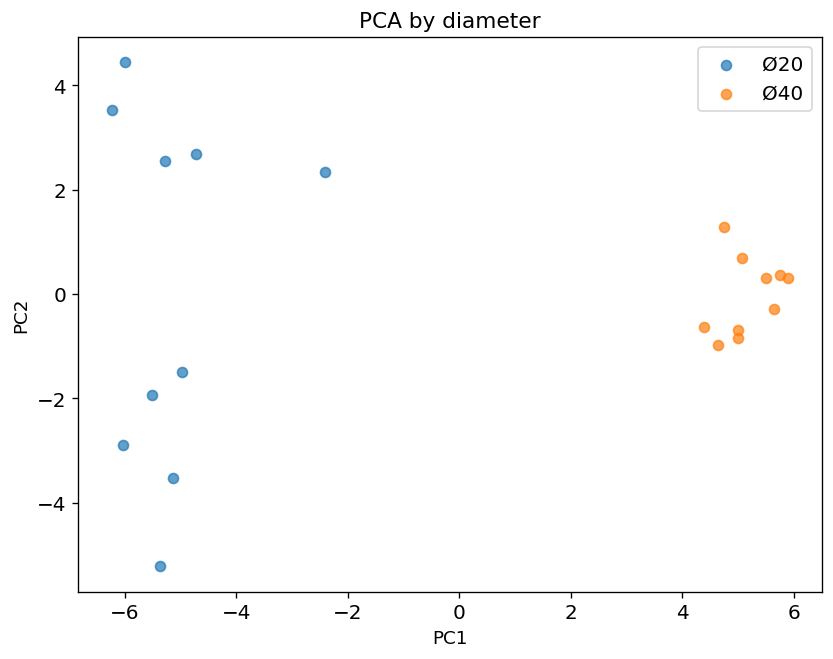

In [82]:
#2D PCA visualization of the feature space, colored by diameter.
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# ---- PC composition (loadings) ----
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=["PC1_loading", "PC2_loading"]
)

# ---- PCA scatter ----
plt.figure(figsize=(8,6))
for d in sorted(meta["diameter_mm"].unique()):
    mask = meta["diameter_mm"] == d
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=f"Ø{d}", alpha=0.7)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("PCA by diameter")
plt.show()

In [83]:
print("Explained variance ratios:", pca.explained_variance_ratio_)

print("\nTop 10 contributors to PC1 (by |loading|):")
print(loadings.reindex(loadings["PC1_loading"].abs().sort_values(ascending=False).index).head(10))

print("\nTop 10 contributors to PC2 (by |loading|):")
print(loadings.reindex(loadings["PC2_loading"].abs().sort_values(ascending=False).index).head(10))

Explained variance ratios: [0.60717654 0.12273487]

Top 10 contributors to PC1 (by |loading|):
                 PC1_loading  PC2_loading
band_32_mean_db     0.188034     0.005547
ripple_std_db      -0.187931    -0.011399
band_33_mean_db     0.187841    -0.033758
band_24_mean_db     0.186955    -0.020063
band_35_mean_db     0.185952    -0.078371
band_39_mean_db     0.185158     0.061915
band_38_mean_db     0.184306    -0.063013
band_36_mean_db     0.179503     0.066226
band_31_mean_db     0.178895     0.125572
band_26_mean_db     0.178364    -0.121981

Top 10 contributors to PC2 (by |loading|):
                     PC1_loading  PC2_loading
band_30_mean_db         0.097206     0.340569
slope_lo_db_per_dec     0.058768     0.294715
band_03_mean_db         0.106555    -0.287548
band_23_mean_db         0.138279    -0.272116
band_10_mean_db         0.140421     0.223002
band_15_mean_db         0.127663     0.221092
band_34_mean_db         0.152656    -0.210111
band_28_mean_db         0.13598

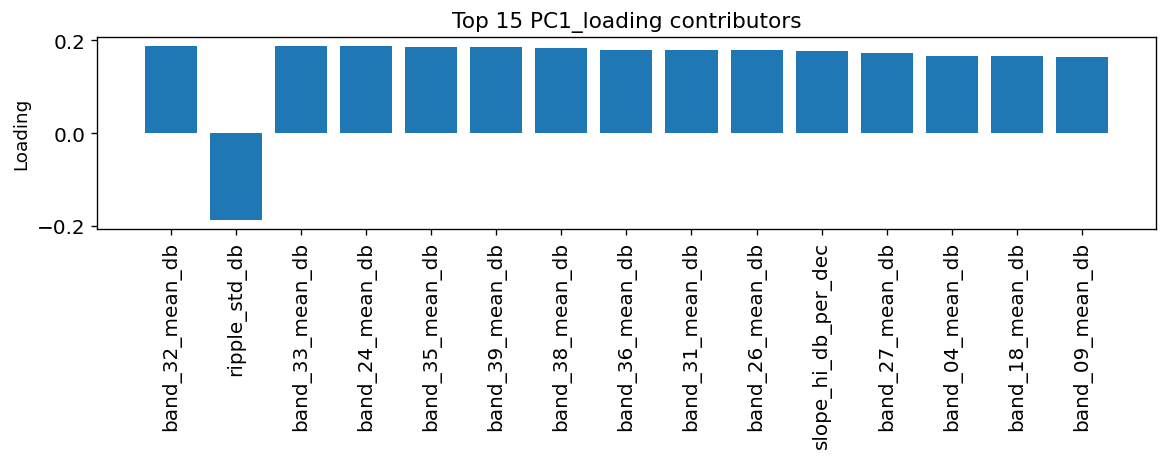

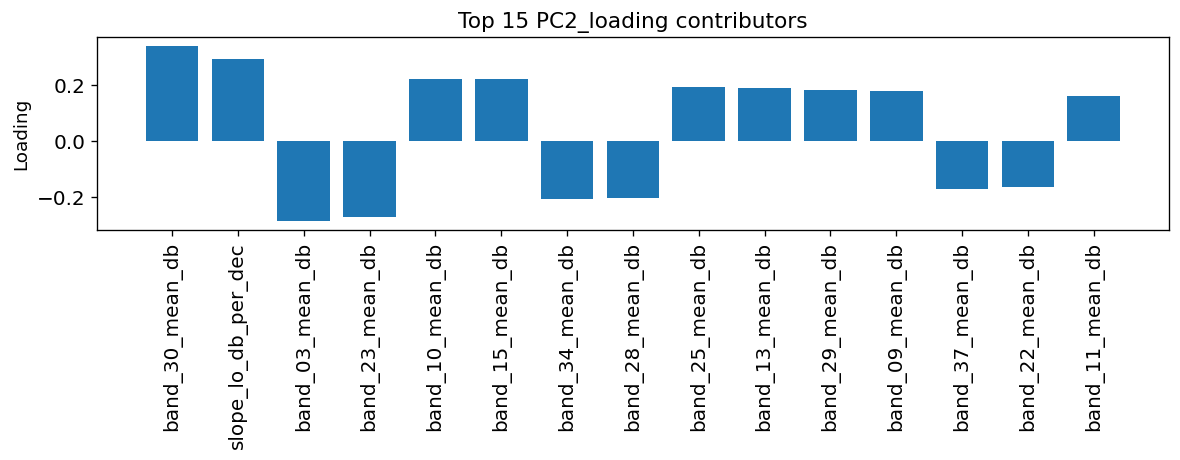

In [84]:
top_n = 15
pc = "PC1_loading"  # change to PC2_loading

top = loadings[pc].abs().sort_values(ascending=False).head(top_n).index
plt.figure(figsize=(10,4))
plt.bar(top, loadings.loc[top, pc])
plt.xticks(rotation=90)
plt.ylabel("Loading")
plt.title(f"Top {top_n} {pc} contributors")
plt.tight_layout()
plt.show()

pc = "PC2_loading"

top = loadings[pc].abs().sort_values(ascending=False).head(top_n).index
plt.figure(figsize=(10,4))
plt.bar(top, loadings.loc[top, pc])
plt.xticks(rotation=90)
plt.ylabel("Loading")
plt.title(f"Top {top_n} {pc} contributors")
plt.tight_layout()
plt.show()

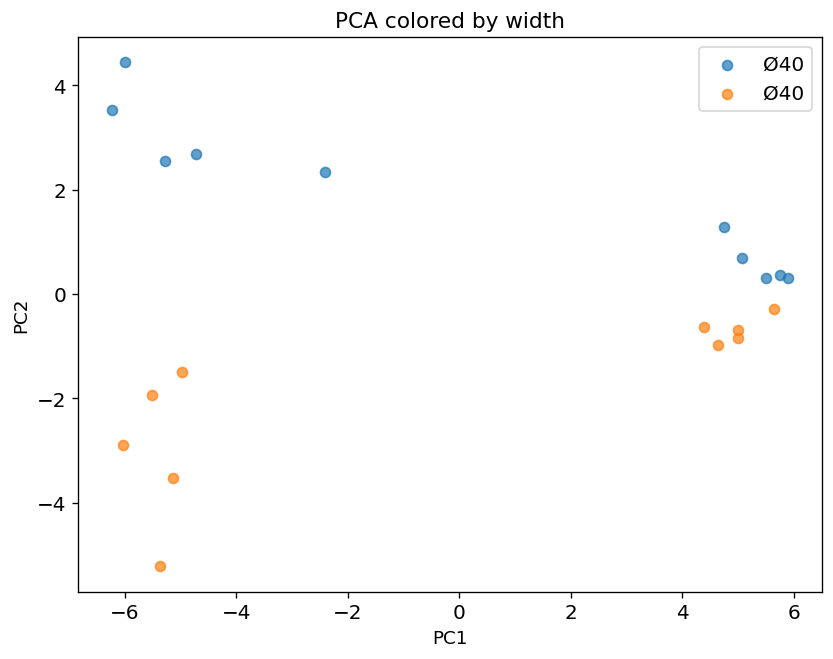

In [85]:
plt.figure(figsize=(8,6))
for w in sorted(meta["width_mm"].unique()):
    mask = meta["width_mm"] == w
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=f"Ø{d}", alpha=0.7)

plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA colored by width")
plt.show()


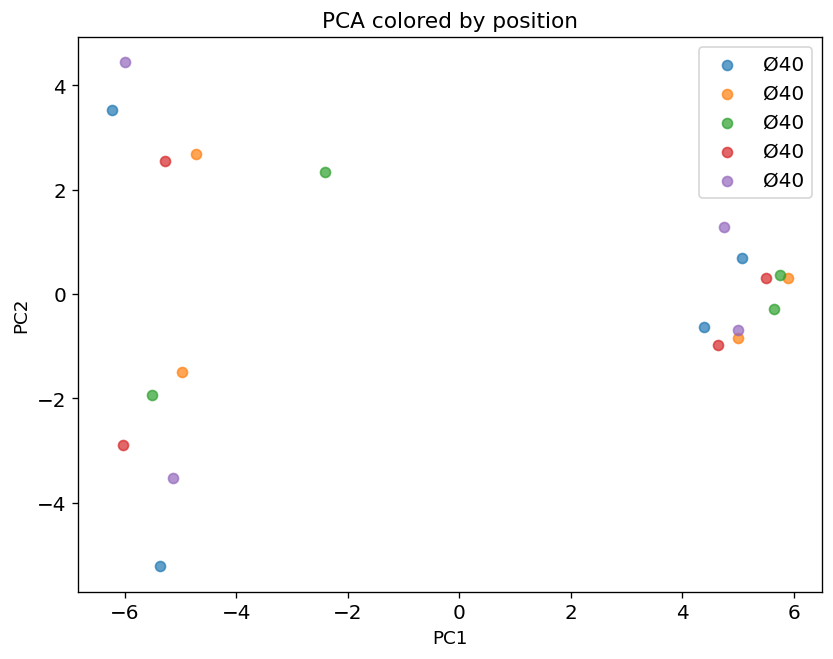

In [86]:
plt.figure(figsize=(8,6))
for pos in sorted(meta["position"].unique()):
    mask = meta["position"] == pos
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=f"Ø{d}", alpha=0.7)

plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA colored by position")
plt.show()


In [87]:
def between_group_variance(col, group):
    means = exp_df.groupby(group)[col].mean()
    return np.var(means)

scores = {col: between_group_variance(col, "diameter_mm") for col in feature_cols}
sorted(scores.items(), key=lambda x: -x[1])[:10]

[('rolloff_6db_hz', np.float64(3650096.073746681)),
 ('band_38_mean_db', np.float64(69.39039649880581)),
 ('band_39_mean_db', np.float64(23.35342886261648)),
 ('band_37_mean_db', np.float64(17.524953557898822)),
 ('slope_hi_db_per_dec', np.float64(16.048881828515597)),
 ('band_25_mean_db', np.float64(14.817176662645055)),
 ('band_26_mean_db', np.float64(13.853491853785515)),
 ('band_27_mean_db', np.float64(12.76452109797853)),
 ('band_24_mean_db', np.float64(10.637160465135393)),
 ('band_32_mean_db', np.float64(9.684369181393105))]

#### Ø-subset PCA


In [88]:
def run_pca_report(
    X_sub: pd.DataFrame,
    meta_sub: pd.DataFrame,
    color_by: str,
    title: str,
    top_n: int = 15,
):
    # scale + fit
    X_scaled = StandardScaler().fit_transform(X_sub)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # loadings
    loadings = pd.DataFrame(
        pca.components_.T,
        index=X_sub.columns,
        columns=["PC1_loading", "PC2_loading"]
    )

    # scatter
    plt.figure(figsize=(8,6))
    for g in sorted(meta_sub[color_by].unique()):
        m = meta_sub[color_by] == g
        plt.scatter(X_pca[m,0], X_pca[m,1], label=str(g), alpha=0.7)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title=color_by)
    plt.title(title)
    plt.show()

    # text report
    print("Explained variance ratios:", pca.explained_variance_ratio_)

    print("\nTop 10 contributors to PC1 (by |loading|):")
    print(loadings.reindex(loadings["PC1_loading"].abs().sort_values(ascending=False).index).head(10))

    print("\nTop 10 contributors to PC2 (by |loading|):")
    print(loadings.reindex(loadings["PC2_loading"].abs().sort_values(ascending=False).index).head(10))

    # bar plots
    for pc in ["PC1_loading", "PC2_loading"]:
        top = loadings[pc].abs().sort_values(ascending=False).head(top_n).index
        plt.figure(figsize=(10,4))
        plt.bar(top, loadings.loc[top, pc])
        plt.xticks(rotation=90)
        plt.ylabel("Loading")
        plt.title(f"{title} — Top {top_n} {pc} contributors")
        plt.tight_layout()
        plt.show()

    return pca, loadings, X_pca

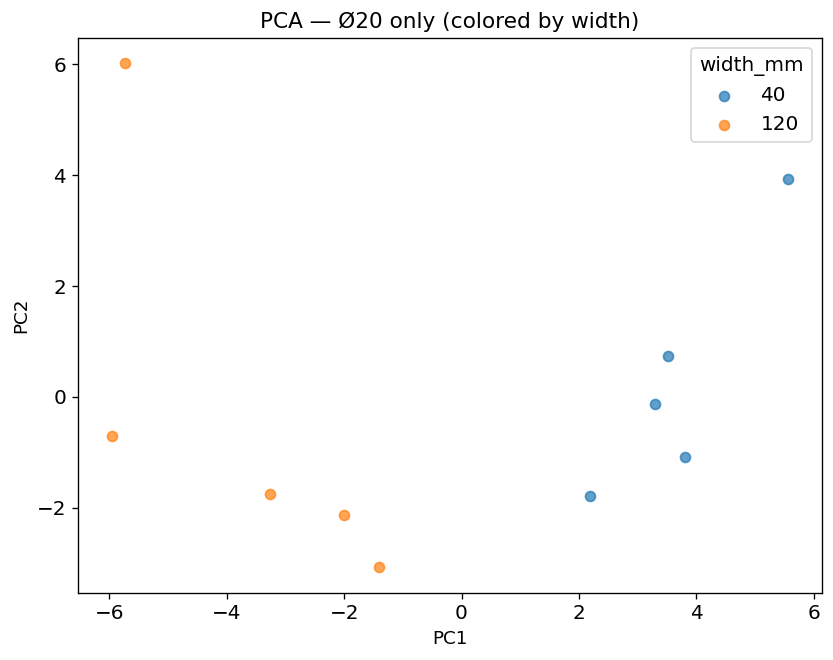

Explained variance ratios: [0.35278675 0.16493116]

Top 10 contributors to PC1 (by |loading|):
                 PC1_loading  PC2_loading
band_25_mean_db     0.237340    -0.043024
band_23_mean_db    -0.234833     0.018094
band_30_mean_db     0.230714     0.022731
band_34_mean_db    -0.223550    -0.137543
band_27_mean_db     0.214937    -0.025105
band_35_mean_db    -0.210003    -0.140709
band_39_mean_db     0.208982     0.166417
rolloff_6db_hz     -0.207544     0.108956
band_37_mean_db    -0.206021     0.137438
band_28_mean_db    -0.202175    -0.175074

Top 10 contributors to PC2 (by |loading|):
                     PC1_loading  PC2_loading
band_16_mean_db         0.098741     0.277675
band_32_mean_db         0.061879     0.251749
band_20_mean_db        -0.123982    -0.249839
ripple_std_db          -0.093686    -0.243081
slope_hi_db_per_dec    -0.112928     0.236410
band_10_mean_db         0.169575    -0.224920
band_19_mean_db         0.021338    -0.214180
band_33_mean_db        -0.12515

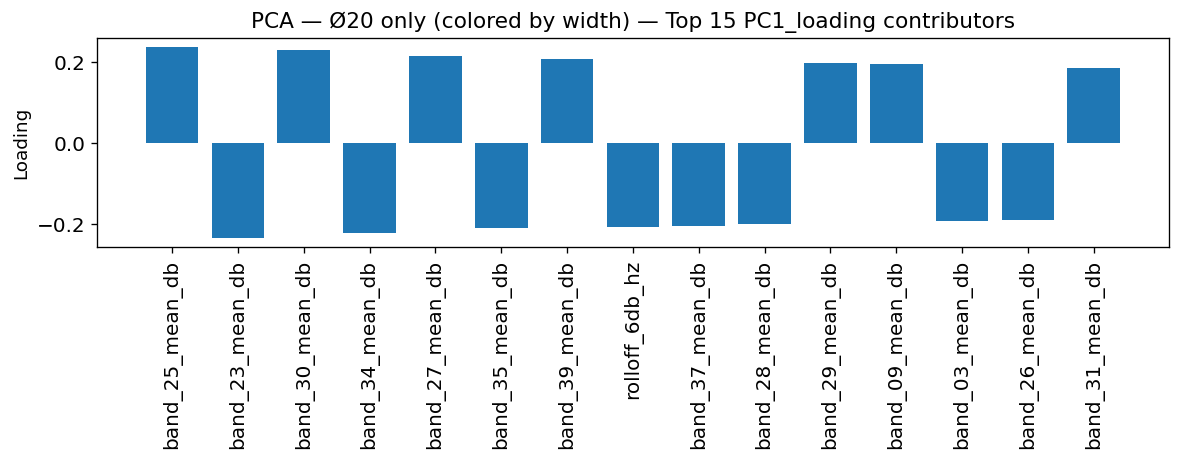

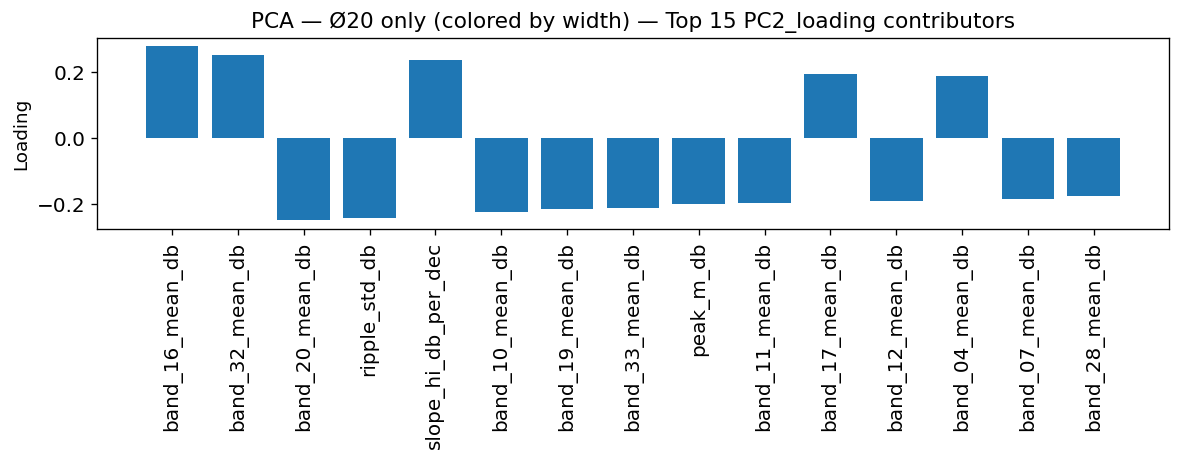

In [89]:
mask20 = meta["diameter_mm"] == 20
pca20, load20, Xpca20 = run_pca_report(
    X_sub=X.loc[mask20],
    meta_sub=meta.loc[mask20],
    color_by="width_mm",
    title="PCA — Ø20 only (colored by width)",
    top_n=15,
)

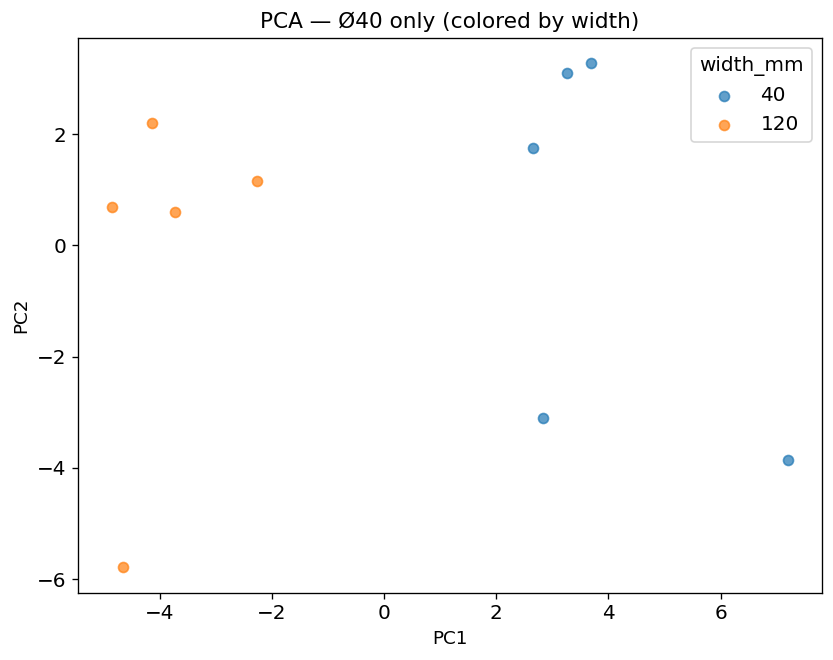

Explained variance ratios: [0.38297401 0.19629228]

Top 10 contributors to PC1 (by |loading|):
                 PC1_loading  PC2_loading
band_31_mean_db     0.230889     0.057121
band_38_mean_db    -0.228964    -0.003056
band_36_mean_db     0.225865     0.079221
ripple_std_db      -0.213403    -0.115942
band_34_mean_db     0.211513     0.055142
band_26_mean_db    -0.209779     0.020364
band_35_mean_db     0.208298     0.045526
band_29_mean_db     0.204575     0.033072
band_30_mean_db     0.204008    -0.042597
band_06_mean_db    -0.195619     0.133131

Top 10 contributors to PC2 (by |loading|):
                 PC1_loading  PC2_loading
band_07_mean_db     0.073495     0.298354
band_05_mean_db    -0.049865     0.295182
band_02_mean_db    -0.090286     0.289520
band_12_mean_db     0.041126     0.246047
band_11_mean_db     0.121076     0.243592
band_24_mean_db    -0.076971     0.224656
band_22_mean_db     0.124052    -0.221715
peak_m_db           0.141192     0.212872
band_08_mean_db    -0

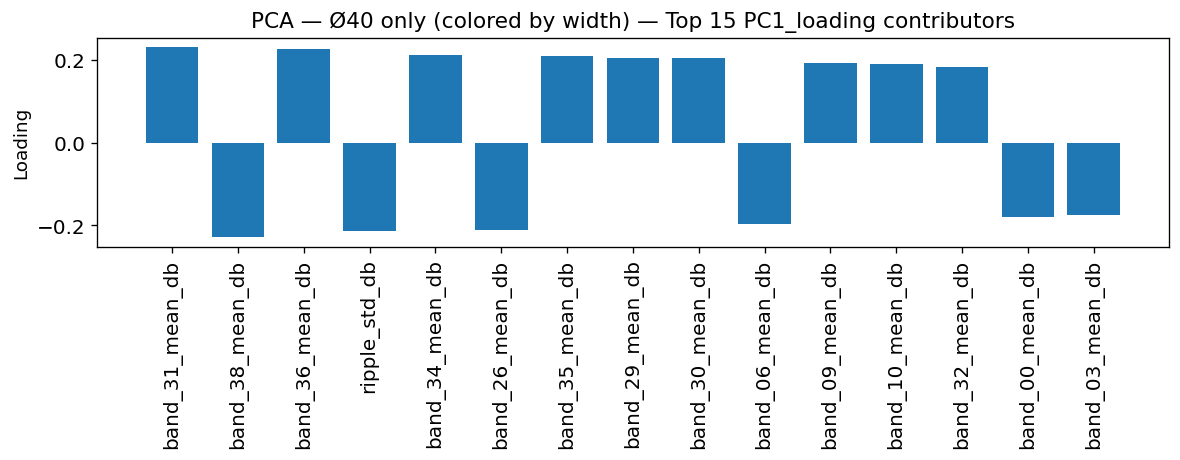

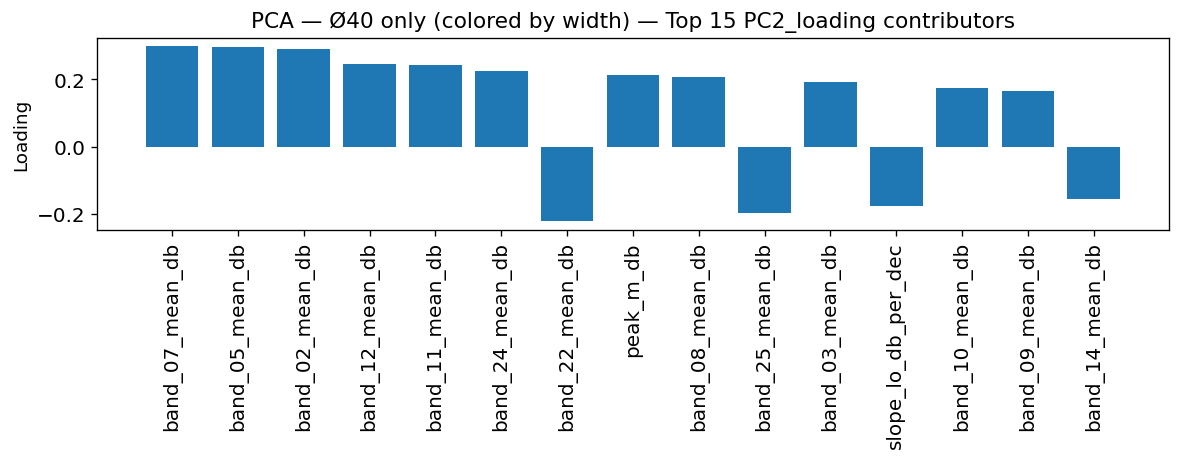

In [90]:
mask40 = meta["diameter_mm"] == 40
pca40, load40, Xpca40 = run_pca_report(
    X_sub=X.loc[mask40],
    meta_sub=meta.loc[mask40],
    color_by="width_mm",
    title="PCA — Ø40 only (colored by width)",
    top_n=15,
)

## 1 sweep = 1 obs, data analysis

In [91]:
# Sweep-level pipeline: 1 aligned sweep = 1 observation

def per_sweep_mag_spectra_from_aligned(
    y: np.ndarray,
    fs: int,
    start_idx: int,
    sweep_len: int,
    nfft: int | None = None,
    min_sweeps: int = 5,
    max_sweeps: int | None = None,
    window: str = "hann",
):
    """
    Returns per-sweep |Y(f)| without averaging across sweeps.
    Output: f, M (shape: n_used x n_freq), n_used
    """
    y = np.asarray(y).ravel()
    start_idx = int(start_idx)

    if start_idx < 0 or start_idx >= len(y):
        raise ValueError("start_idx out of bounds.")

    n_full = (len(y) - start_idx) // sweep_len
    if n_full < min_sweeps:
        raise ValueError(f"Only {n_full} full sweeps available; need at least {min_sweeps}.")

    n_used = n_full if max_sweeps is None else min(n_full, max_sweeps)

    if nfft is None:
        nfft = int(2 ** np.ceil(np.log2(sweep_len)))

    w = window.lower()
    if w in ("hann", "hanning"):
        win = np.hanning(sweep_len).astype(np.float32)
    elif w in ("rect", "rectangular", "boxcar", "none"):
        win = np.ones(sweep_len, dtype=np.float32)
    else:
        raise ValueError(f"Unknown window: {window}")

    mags = []
    for k in range(n_used):
        i0 = start_idx + k * sweep_len
        i1 = i0 + sweep_len
        seg = y[i0:i1] * win
        Y = np.fft.rfft(seg, n=nfft)
        mags.append(np.abs(Y).astype(np.float64))

    M = np.vstack(mags)
    f = np.fft.rfftfreq(nfft, d=1 / fs)
    return f, M, n_used


def build_sweep_level_transfer_df(
    exp_df: pd.DataFrame,
    baseline_df: pd.DataFrame,
    x_sweep: np.ndarray,
    signal_col: str = "y",
    fs_col: str = "fs",
    start_col: str = "sweep_start_idx",
    min_sweeps: int = 5,
    max_sweeps: int | None = None,
    nfft: int | None = None,
    window: str = "hann",
    eps: float = 1e-12,
) -> tuple[pd.DataFrame, dict]:
    """
    Build sweep_df where each row is one sweep from one sample.
    Relative curve is computed vs one baseline averaged spectrum.
    """
    exp_work = exp_df.copy().reset_index(drop=False).rename(columns={"index": "sample_id"})

    if exp_work[fs_col].nunique() != 1 or baseline_df[fs_col].nunique() != 1:
        raise ValueError("Different fs detected; handle per-row fs or resample.")
    fs_exp = int(exp_work[fs_col].iloc[0])
    fs_base = int(baseline_df[fs_col].iloc[0])
    if fs_exp != fs_base:
        raise ValueError("Baseline fs differs from experiment fs.")

    sweep_len = len(x_sweep)
    fixed_nfft = nfft if nfft is not None else int(2 ** np.ceil(np.log2(sweep_len)))

    # Reuse existing sample-level helper for baseline average (same as above pipeline)
    b = baseline_df.iloc[0]
    f_base, mag_base, n_base = avg_mag_spectrum_from_aligned(
        y=b[signal_col],
        fs=fs_exp,
        start_idx=b[start_col],
        sweep_len=sweep_len,
        nfft=fixed_nfft,
        min_sweeps=min_sweeps,
        max_sweeps=max_sweeps,
        window=window,
    )

    records = []
    for row in exp_work.itertuples(index=False):
        f, Mexp, n_used = per_sweep_mag_spectra_from_aligned(
            y=getattr(row, signal_col),
            fs=fs_exp,
            start_idx=getattr(row, start_col),
            sweep_len=sweep_len,
            nfft=fixed_nfft,
            min_sweeps=min_sweeps,
            max_sweeps=max_sweeps,
            window=window,
        )

        if len(f) != len(f_base) or not np.allclose(f, f_base):
            raise ValueError("Frequency grids differ. Use a fixed nfft.")

        for k in range(n_used):
            M_rel_db = 20.0 * np.log10((Mexp[k] + eps) / (mag_base + eps))
            records.append(
                {
                    "sample_id": int(getattr(row, "sample_id")),
                    "sweep_idx": int(k),
                    "diameter_mm": getattr(row, "diameter_mm"),
                    "width_mm": getattr(row, "width_mm"),
                    "position": getattr(row, "position"),
                    "f": f_base,
                    "M_rel_db": M_rel_db,
                    "n_sweeps_in_sample": int(n_used),
                    "n_sweeps_used_baseline": int(n_base),
                }
            )

    sweep_df = pd.DataFrame.from_records(records)
    diag = {
        "f_base": f_base,
        "mag_base": mag_base,
        "n_base": int(n_base),
        "fs": int(fs_exp),
        "sweep_len": int(sweep_len),
        "nfft": int(fixed_nfft),
    }
    return sweep_df, diag


# Build sweep-level transfer curves, then reuse existing feature extractor
sweep_df, sweep_diag = build_sweep_level_transfer_df(
    exp_df=exp_df,
    baseline_df=baseline_df,
    x_sweep=x_sweep,
    min_sweeps=5,
    max_sweeps=None,
    nfft=None,
    window="hann",
)

sweep_df = add_transfer_features(sweep_df, f_col="f", M_col="M_rel_db")

# Feature table for ML (sweep-level)
feature_cols_sweep = (
    [c for c in sweep_df.columns if c.startswith("band_")] +
    [
        "slope_lo_db_per_dec",
        "slope_hi_db_per_dec",
        "rolloff_6db_hz",
        "peak_f_hz",
        "peak_m_db",
        "ripple_std_db",
    ]
)

X_sweep = sweep_df[feature_cols_sweep].copy()
meta_sweep = sweep_df[["sample_id", "sweep_idx", "diameter_mm", "width_mm", "position"]].copy()

print("sweep-level rows:", len(sweep_df))
print("unique samples:", sweep_df["sample_id"].nunique())
print("mean sweeps/sample:", round(sweep_df.groupby("sample_id").size().mean(), 2))
sweep_df[["sample_id", "sweep_idx", "diameter_mm", "width_mm", "position", "n_sweeps_in_sample"]].head()

sweep-level rows: 806
unique samples: 20
mean sweeps/sample: 40.3


,sample_id,sweep_idx,diameter_mm,width_mm,position,n_sweeps_in_sample
0,0,0,20,40,1,52
1,0,1,20,40,1,52
2,0,2,20,40,1,52
3,0,3,20,40,1,52
4,0,4,20,40,1,52


### 2D PCA (sweep-level)

band_00_mean_db    0.0
band_01_mean_db    0.0
band_02_mean_db    0.0
band_03_mean_db    0.0
band_04_mean_db    0.0
dtype: float64


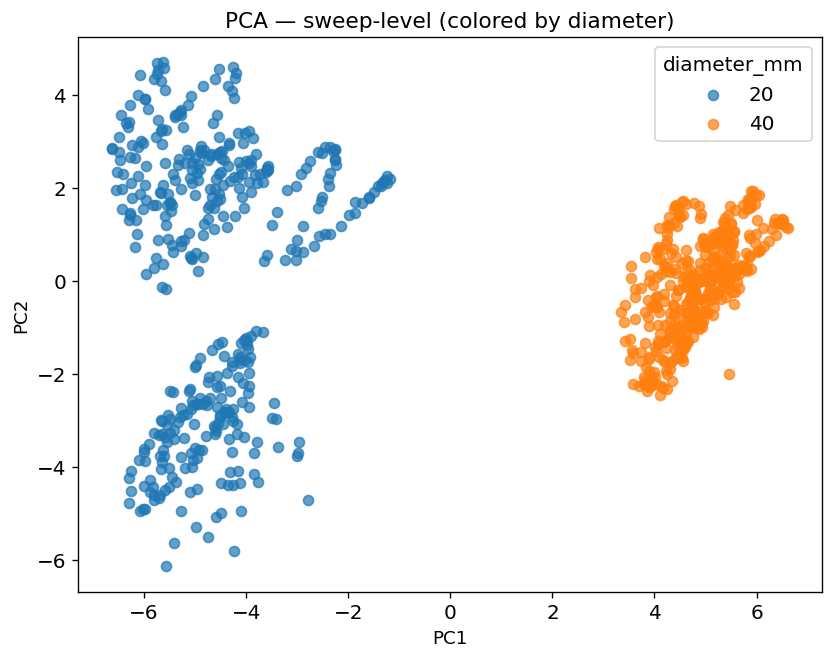

Explained variance ratios: [0.52028485 0.10662102]

Top 10 contributors to PC1 (by |loading|):
                     PC1_loading  PC2_loading
band_32_mean_db         0.202433     0.011937
ripple_std_db          -0.201714     0.003348
band_33_mean_db         0.201408    -0.047887
band_38_mean_db         0.199207    -0.054617
band_35_mean_db         0.199081    -0.101500
band_24_mean_db         0.197535    -0.018161
band_39_mean_db         0.197417     0.068904
band_26_mean_db         0.194409    -0.110718
slope_hi_db_per_dec     0.191714    -0.030775
band_31_mean_db         0.189549     0.110677

Top 10 contributors to PC2 (by |loading|):
                     PC1_loading  PC2_loading
band_30_mean_db         0.080161     0.361521
slope_lo_db_per_dec     0.045449     0.296337
band_23_mean_db         0.156589    -0.262681
band_15_mean_db         0.093736     0.259798
band_28_mean_db         0.147745    -0.246536
band_16_mean_db         0.107959     0.243733
band_03_mean_db         0.122990 

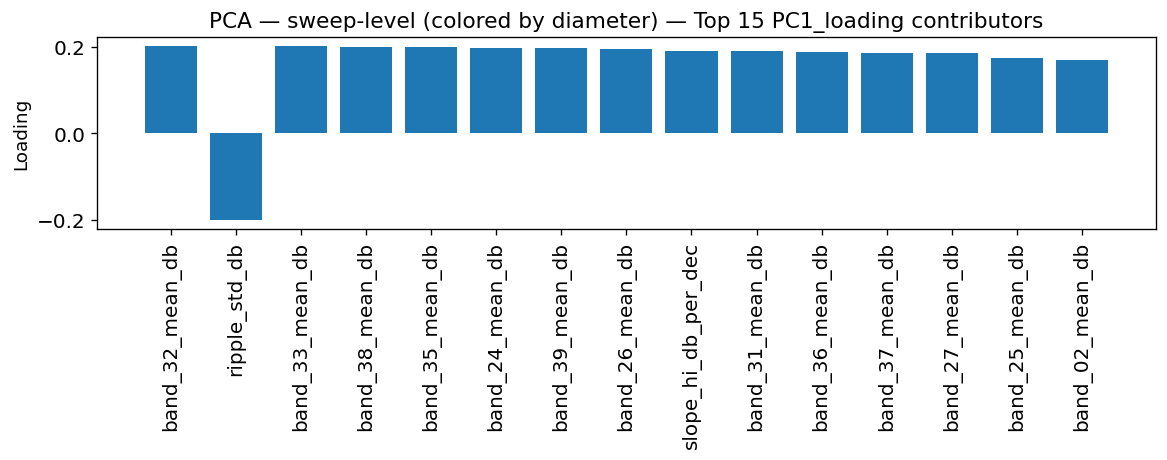

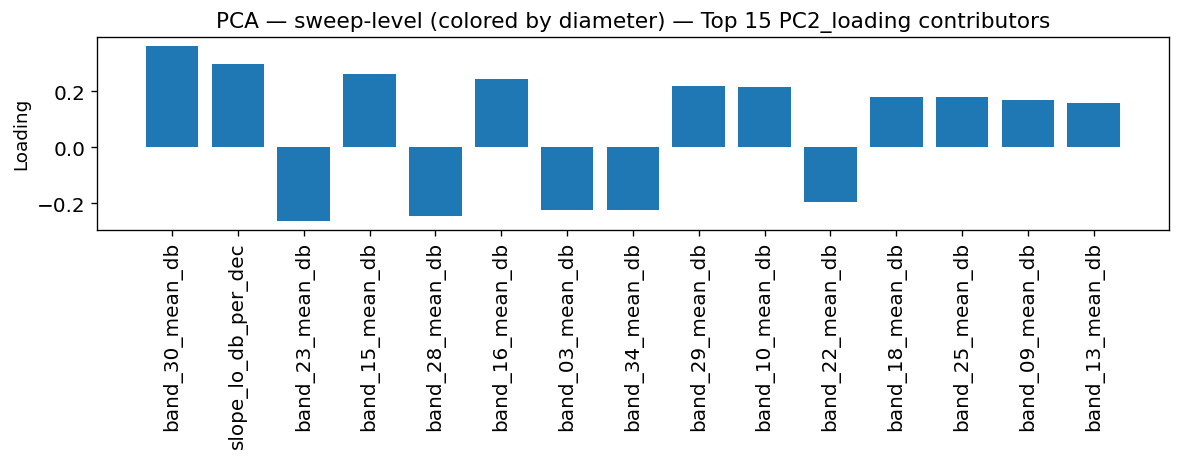

In [92]:
# Optional sanity check for missing values in sweep-level feature matrix
print(X_sweep.isna().mean().sort_values(ascending=False).head())

# Reuse existing PCA helper from above
pca_sweep, load_sweep, Xpca_sweep = run_pca_report(
    X_sub=X_sweep,
    meta_sub=meta_sweep,
    color_by="diameter_mm",
    title="PCA — sweep-level (colored by diameter)",
    top_n=15,
)

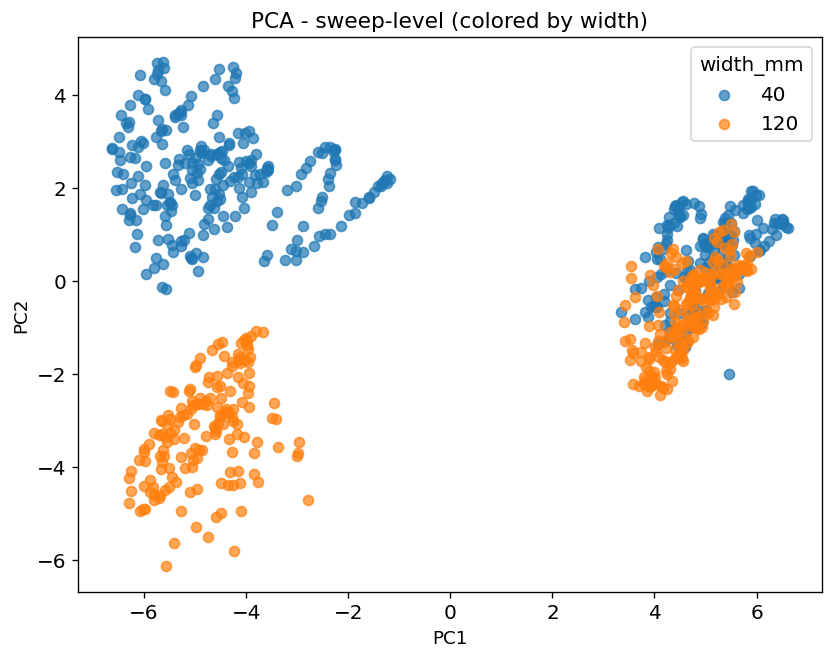

Explained variance ratios: [0.52028485 0.10662102]

Top 10 contributors to PC1 (by |loading|):
                     PC1_loading  PC2_loading
band_32_mean_db         0.202433     0.011937
ripple_std_db          -0.201714     0.003348
band_33_mean_db         0.201408    -0.047887
band_38_mean_db         0.199207    -0.054617
band_35_mean_db         0.199081    -0.101500
band_24_mean_db         0.197535    -0.018161
band_39_mean_db         0.197417     0.068904
band_26_mean_db         0.194409    -0.110718
slope_hi_db_per_dec     0.191714    -0.030775
band_31_mean_db         0.189549     0.110677

Top 10 contributors to PC2 (by |loading|):
                     PC1_loading  PC2_loading
band_30_mean_db         0.080161     0.361521
slope_lo_db_per_dec     0.045449     0.296337
band_23_mean_db         0.156589    -0.262681
band_15_mean_db         0.093736     0.259798
band_28_mean_db         0.147745    -0.246536
band_16_mean_db         0.107959     0.243733
band_03_mean_db         0.122990 

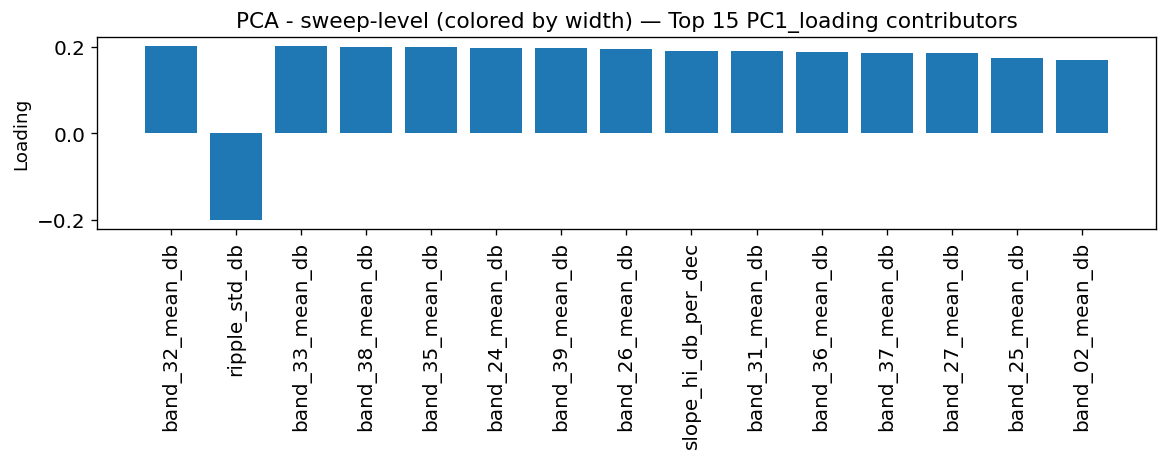

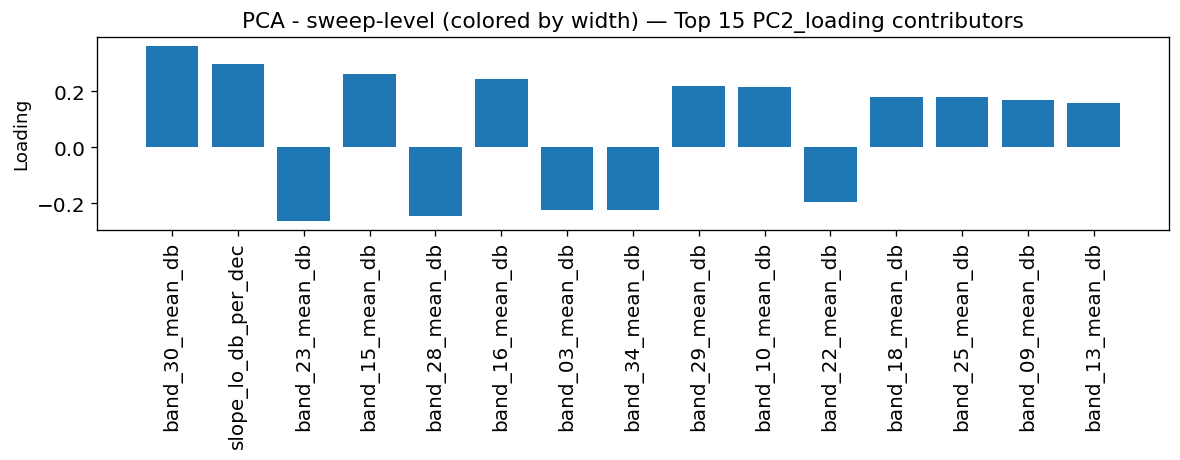

In [93]:
pca_sweep_w, load_sweep_w, Xpca_sweep_w = run_pca_report(
     X_sub=X_sweep,
     meta_sub=meta_sweep,
     color_by="width_mm",
     title="PCA - sweep-level (colored by width)",
     top_n=15,
 )


c:\Users\sindr\Documents\Code\acoustic blockage sensor\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


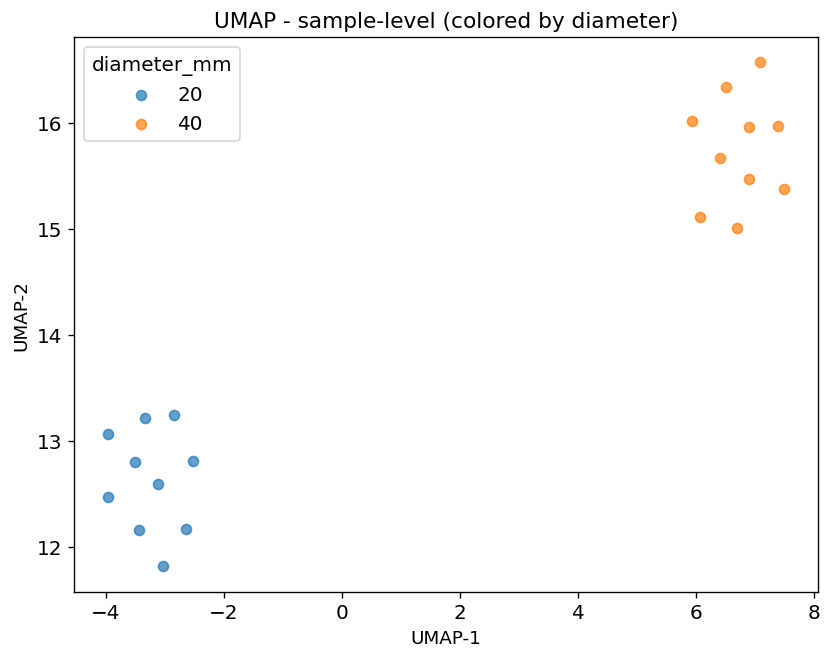

c:\Users\sindr\Documents\Code\acoustic blockage sensor\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


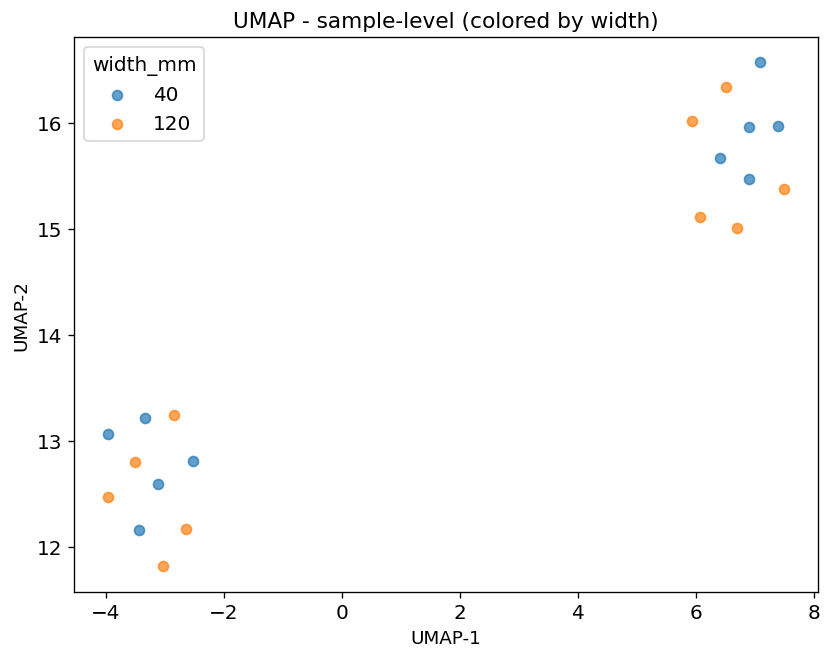

c:\Users\sindr\Documents\Code\acoustic blockage sensor\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


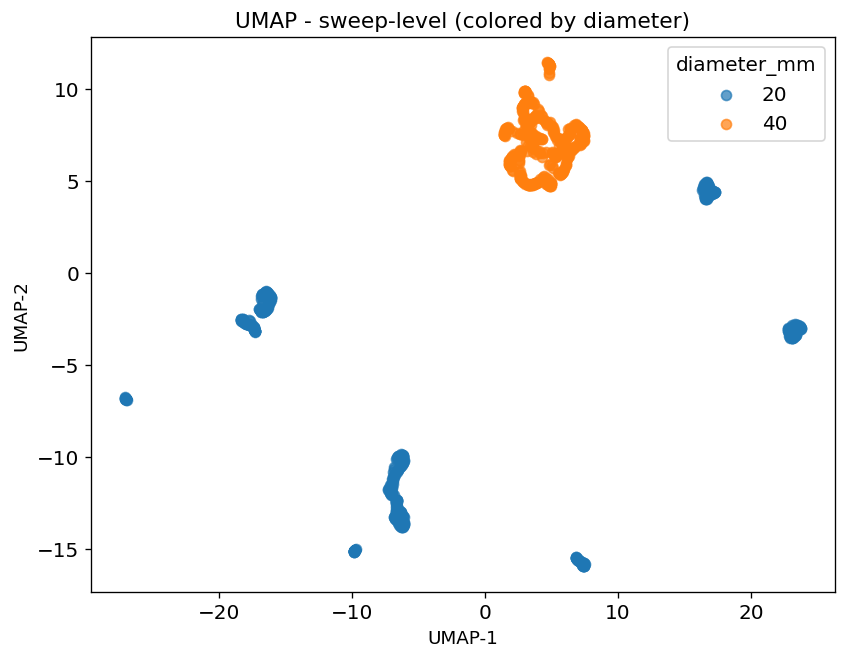

c:\Users\sindr\Documents\Code\acoustic blockage sensor\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


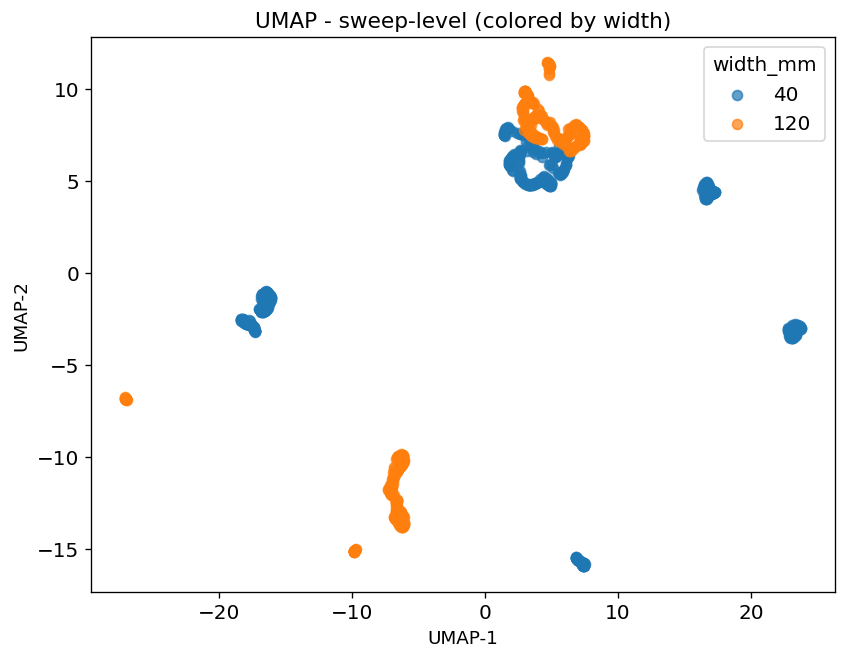

In [94]:
# UMAP alternative to PCA using the same engineered feature spaces.
def run_umap_report(
    X_sub: pd.DataFrame,
    meta_sub: pd.DataFrame,
    color_by: str,
    title: str,
    n_neighbors: int = 10,
    min_dist: float = 0.1,
    metric: str = "euclidean",
    random_state: int = 42,
):
    X_scaled = StandardScaler().fit_transform(X_sub)

    umap_model = UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
    )
    X_umap = umap_model.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    for g in sorted(meta_sub[color_by].unique()):
        m = meta_sub[color_by] == g
        plt.scatter(X_umap[m, 0], X_umap[m, 1], label=str(g), alpha=0.7)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title=color_by)
    plt.title(title)
    plt.show()

    return umap_model, X_umap

# Sample-level UMAP (same X/meta used in PCA section)
umap_sample_d, Xumap_sample_d = run_umap_report(
    X_sub=X,
    meta_sub=meta,
    color_by="diameter_mm",
    title="UMAP - sample-level (colored by diameter)",
    n_neighbors=10,
    min_dist=0.1,
    metric="euclidean",
)

umap_sample_w, Xumap_sample_w = run_umap_report(
    X_sub=X,
    meta_sub=meta,
    color_by="width_mm",
    title="UMAP - sample-level (colored by width)",
    n_neighbors=10,
    min_dist=0.1,
    metric="euclidean",
)

# Sweep-level UMAP (same X_sweep/meta_sweep used in PCA section)
umap_sweep_d, Xumap_sweep_d = run_umap_report(
    X_sub=X_sweep,
    meta_sub=meta_sweep,
    color_by="diameter_mm",
    title="UMAP - sweep-level (colored by diameter)",
    n_neighbors=15,
    min_dist=0.05,
    metric="euclidean",
)

umap_sweep_w, Xumap_sweep_w = run_umap_report(
    X_sub=X_sweep,
    meta_sub=meta_sweep,
    color_by="width_mm",
    title="UMAP - sweep-level (colored by width)",
    n_neighbors=15,
    min_dist=0.05,
    metric="euclidean",
)
